### This notebook is the main notebook running the strategies on a rolling window of 6 months of training for 1 month of testing. 
### Note that the first two cells must be executed first, then each part of the notebook is independent

In [1]:
import torch
import numpy as np
import pandas as pd
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import gc
from importlib import reload

In [2]:
# IF EXECUTING ON COLLAB UNCOMMENT THIS CELL

#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())

# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

# Let's run the model on the whole period, without firm characteristics

In [3]:
daily = utils.read_daily_returns(path, low_quantile=0.005, up_quantile=0.995)
daily

Number of daily return outliers: 465,274


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000
...,...,...,...,...,...,...,...,...
46530040,2024-12-31,60118,26023,9999,0,-0.000393,-0.004285,-0.010702
46530041,2024-12-31,60120,26027,9999,523910,-0.133929,-0.004285,-0.010702
46530042,2024-12-31,60121,26034,9999,0,0.108590,-0.004285,-0.010702
46530043,2024-12-31,60122,26035,9999,551112,-0.034979,-0.004285,-0.010702


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0           2000-01
8329        2000-02
174757      2000-03
365885      2000-04
523862      2000-05
             ...   
45509829    2024-08
45719273    2024-09
45910745    2024-10
46132558    2024-11
46325971    2024-12
Name: year_month, Length: 300, dtype: period[M]

In [5]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, len(unique_months) - 6):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+5]
    test_month = unique_months.iloc[i+6]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 4 # It appears it is the ideal trade-off between precision and runtime
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.30% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-06. Testing on 2000-07.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 435 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.15s/it]

Epoch 1/4, Loss: -0.0616, Train fit: 0.0004, Test fit: -0.0212, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.70s/it]

Epoch 3/4, Loss: -0.0784, Train fit: 0.0287, Test fit: 0.0210, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.86s/it]

Epoch 4/4, Loss: -0.0970, Train fit: 0.0432, Test fit: 0.0390, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0390
Training from 2000-02 to 2000-07. Testing on 2000-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 512 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:50, 16.72s/it]

Epoch 1/4, Loss: -0.0712, Train fit: 0.0103, Test fit: 0.0513, Avg Weight: 0.0002, Max Weight: 0.0018


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.38s/it]

Epoch 3/4, Loss: -0.1042, Train fit: 0.0550, Test fit: 0.0749, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.38s/it]

Epoch 4/4, Loss: -0.1152, Train fit: 0.0580, Test fit: 0.0768, Avg Weight: 0.0002, Max Weight: 0.0024
Training completed! Best test Sharpe ratio: 0.0768
Training from 2000-03 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 525 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.43s/it]

Epoch 1/4, Loss: -0.0714, Train fit: 0.0121, Test fit: -0.0178, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:52<00:17, 17.68s/it]

Epoch 3/4, Loss: -0.1109, Train fit: 0.0460, Test fit: 0.0183, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.71s/it]

Epoch 4/4, Loss: -0.1179, Train fit: 0.0517, Test fit: 0.0241, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.0241
Training from 2000-04 to 2000-09. Testing on 2000-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 513 train batches, 45 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.51s/it]

Epoch 1/4, Loss: -0.0679, Train fit: 0.0057, Test fit: -0.0102, Avg Weight: 0.0002, Max Weight: 0.0108


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.72s/it]

Epoch 3/4, Loss: -0.1081, Train fit: 0.0551, Test fit: 0.0370, Avg Weight: 0.0002, Max Weight: 0.0026


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.61s/it]

Epoch 4/4, Loss: -0.1181, Train fit: 0.0570, Test fit: 0.0404, Avg Weight: 0.0002, Max Weight: 0.0032
Training completed! Best test Sharpe ratio: 0.0404
Training from 2000-05 to 2000-10. Testing on 2000-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 525 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:50, 16.82s/it]

Epoch 1/4, Loss: -0.0653, Train fit: 0.0101, Test fit: -0.0591, Avg Weight: 0.0002, Max Weight: 0.0021


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.90s/it]

Epoch 3/4, Loss: -0.1154, Train fit: 0.0638, Test fit: 0.0065, Avg Weight: 0.0002, Max Weight: 0.0030


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.91s/it]

Epoch 4/4, Loss: -0.1222, Train fit: 0.0651, Test fit: 0.0125, Avg Weight: 0.0002, Max Weight: 0.0034
Training completed! Best test Sharpe ratio: 0.0125
Training from 2000-06 to 2000-11. Testing on 2000-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 520 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.49s/it]

Epoch 1/4, Loss: -0.0697, Train fit: 0.0080, Test fit: 0.0257, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.48s/it]

Epoch 3/4, Loss: -0.1102, Train fit: 0.0592, Test fit: 0.0574, Avg Weight: 0.0002, Max Weight: 0.0058


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.58s/it]

Epoch 4/4, Loss: -0.1175, Train fit: 0.0617, Test fit: 0.0585, Avg Weight: 0.0002, Max Weight: 0.0062
Training completed! Best test Sharpe ratio: 0.0585
Training from 2000-07 to 2000-12. Testing on 2001-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 511 train batches, 42 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.44s/it]

Epoch 1/4, Loss: -0.0682, Train fit: 0.0170, Test fit: 0.0749, Avg Weight: 0.0002, Max Weight: 0.0032


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.39s/it]

Epoch 3/4, Loss: -0.1078, Train fit: 0.0432, Test fit: 0.0930, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.59s/it]

Epoch 4/4, Loss: -0.1136, Train fit: 0.0436, Test fit: 0.0894, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0940
Training from 2000-08 to 2001-01. Testing on 2001-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 512 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.98s/it]

Epoch 1/4, Loss: -0.0733, Train fit: 0.0032, Test fit: -0.0760, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.16s/it]

Epoch 3/4, Loss: -0.1132, Train fit: 0.0362, Test fit: -0.0361, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.24s/it]

Epoch 4/4, Loss: -0.1197, Train fit: 0.0407, Test fit: -0.0309, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: -0.0309
Training from 2000-09 to 2001-02. Testing on 2001-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 493 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.55s/it]

Epoch 1/4, Loss: -0.0554, Train fit: 0.0010, Test fit: -0.0224, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.76s/it]

Epoch 3/4, Loss: -0.1020, Train fit: 0.0545, Test fit: 0.0450, Avg Weight: 0.0002, Max Weight: 0.0028


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.67s/it]

Epoch 4/4, Loss: -0.1115, Train fit: 0.0565, Test fit: 0.0456, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0456
Training from 2000-10 to 2001-03. Testing on 2001-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 497 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.55s/it]

Epoch 1/4, Loss: -0.0557, Train fit: 0.0145, Test fit: 0.0451, Avg Weight: 0.0002, Max Weight: 0.0040


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.93s/it]

Epoch 3/4, Loss: -0.1016, Train fit: 0.0561, Test fit: 0.0762, Avg Weight: 0.0002, Max Weight: 0.0054


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.88s/it]

Epoch 4/4, Loss: -0.1100, Train fit: 0.0584, Test fit: 0.0738, Avg Weight: 0.0002, Max Weight: 0.0054
Training completed! Best test Sharpe ratio: 0.0762
Training from 2000-11 to 2001-04. Testing on 2001-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 485 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.44s/it]

Epoch 1/4, Loss: -0.0638, Train fit: 0.0065, Test fit: 0.0129, Avg Weight: 0.0002, Max Weight: 0.2622


Training:  75%|██████████████████████████▎        | 3/4 [00:55<00:19, 19.63s/it]

Epoch 3/4, Loss: -0.1058, Train fit: 0.0417, Test fit: 0.0163, Avg Weight: 0.0002, Max Weight: 0.2994


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.72s/it]

Epoch 4/4, Loss: -0.1148, Train fit: 0.0493, Test fit: 0.0273, Avg Weight: 0.0002, Max Weight: 0.2869
Training completed! Best test Sharpe ratio: 0.0273
Training from 2000-12 to 2001-05. Testing on 2001-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 484 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.11s/it]

Epoch 1/4, Loss: -0.0836, Train fit: 0.0266, Test fit: 0.0128, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.17s/it]

Epoch 3/4, Loss: -0.1119, Train fit: 0.0517, Test fit: 0.0299, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.43s/it]

Epoch 4/4, Loss: -0.1258, Train fit: 0.0601, Test fit: 0.0350, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0350
Training from 2001-01 to 2001-06. Testing on 2001-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 484 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.93s/it]

Epoch 1/4, Loss: -0.0898, Train fit: 0.0314, Test fit: -0.0084, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.21s/it]

Epoch 3/4, Loss: -0.1176, Train fit: 0.0605, Test fit: 0.0173, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [01:00<00:00, 15.18s/it]

Epoch 4/4, Loss: -0.1261, Train fit: 0.0658, Test fit: 0.0259, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0259
Training from 2001-02 to 2001-07. Testing on 2001-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 480 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.16s/it]

Epoch 1/4, Loss: -0.0718, Train fit: 0.0134, Test fit: -0.0100, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.17s/it]

Epoch 3/4, Loss: -0.1026, Train fit: 0.0505, Test fit: 0.0292, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [01:00<00:00, 15.18s/it]

Epoch 4/4, Loss: -0.1135, Train fit: 0.0535, Test fit: 0.0341, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0341
Training from 2001-03 to 2001-08. Testing on 2001-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 491 train batches, 28 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.07s/it]

Epoch 1/4, Loss: -0.0774, Train fit: 0.0216, Test fit: -0.0737, Avg Weight: 0.0002, Max Weight: 0.0026


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.39s/it]

Epoch 3/4, Loss: -0.1074, Train fit: 0.0587, Test fit: -0.0354, Avg Weight: 0.0002, Max Weight: 0.0021


Training: 100%|███████████████████████████████████| 4/4 [01:00<00:00, 15.20s/it]

Epoch 4/4, Loss: -0.1153, Train fit: 0.0624, Test fit: -0.0349, Avg Weight: 0.0002, Max Weight: 0.0021
Training completed! Best test Sharpe ratio: -0.0349
Training from 2001-04 to 2001-09. Testing on 2001-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 461 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:18<00:55, 18.43s/it]

Epoch 1/4, Loss: -0.0718, Train fit: 0.0036, Test fit: 0.0419, Avg Weight: 0.0002, Max Weight: 0.0028


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:15, 15.85s/it]

Epoch 3/4, Loss: -0.0905, Train fit: 0.0321, Test fit: 0.0508, Avg Weight: 0.0002, Max Weight: 0.0088


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.85s/it]

Epoch 4/4, Loss: -0.1027, Train fit: 0.0342, Test fit: 0.0444, Avg Weight: 0.0002, Max Weight: 0.0088
Training completed! Best test Sharpe ratio: 0.0508
Training from 2001-05 to 2001-10. Testing on 2001-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 469 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.01s/it]

Epoch 1/4, Loss: -0.0689, Train fit: -0.0032, Test fit: 0.0713, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.04s/it]

Epoch 3/4, Loss: -0.1015, Train fit: 0.0342, Test fit: 0.0889, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.94s/it]

Epoch 4/4, Loss: -0.1087, Train fit: 0.0418, Test fit: 0.0855, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0889
Training from 2001-06 to 2001-11. Testing on 2001-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 461 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.05s/it]

Epoch 1/4, Loss: -0.0745, Train fit: -0.0031, Test fit: 0.0586, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.69s/it]

Epoch 3/4, Loss: -0.1035, Train fit: 0.0271, Test fit: 0.0775, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.75s/it]

Epoch 4/4, Loss: -0.1100, Train fit: 0.0336, Test fit: 0.0803, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: 0.0803
Training from 2001-07 to 2001-12. Testing on 2002-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 455 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.96s/it]

Epoch 1/4, Loss: -0.0887, Train fit: 0.0024, Test fit: 0.0073, Avg Weight: 0.0003, Max Weight: 0.0916


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.60s/it]

Epoch 3/4, Loss: -0.1074, Train fit: 0.0288, Test fit: 0.0237, Avg Weight: 0.0003, Max Weight: 0.1152


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.62s/it]

Epoch 4/4, Loss: -0.1117, Train fit: 0.0316, Test fit: 0.0255, Avg Weight: 0.0003, Max Weight: 0.1196
Training completed! Best test Sharpe ratio: 0.0255
Training from 2001-08 to 2002-01. Testing on 2002-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 452 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.52s/it]

Epoch 1/4, Loss: -0.0942, Train fit: 0.0129, Test fit: -0.0228, Avg Weight: 0.0003, Max Weight: 0.0041


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.32s/it]

Epoch 3/4, Loss: -0.1172, Train fit: 0.0487, Test fit: 0.0175, Avg Weight: 0.0003, Max Weight: 0.0043


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.65s/it]

Epoch 4/4, Loss: -0.1198, Train fit: 0.0510, Test fit: 0.0193, Avg Weight: 0.0003, Max Weight: 0.0040
Training completed! Best test Sharpe ratio: 0.0193
Training from 2001-09 to 2002-02. Testing on 2002-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 435 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.82s/it]

Epoch 1/4, Loss: -0.0951, Train fit: 0.0111, Test fit: 0.0769, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.67s/it]

Epoch 3/4, Loss: -0.0910, Train fit: 0.0368, Test fit: 0.0927, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.82s/it]

Epoch 4/4, Loss: -0.1044, Train fit: 0.0464, Test fit: 0.0940, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: 0.0940
Training from 2001-10 to 2002-03. Testing on 2002-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 451 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.44s/it]

Epoch 1/4, Loss: -0.1057, Train fit: 0.0461, Test fit: 0.0079, Avg Weight: 0.0002, Max Weight: 0.0032


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.32s/it]

Epoch 3/4, Loss: -0.1259, Train fit: 0.0661, Test fit: 0.0318, Avg Weight: 0.0002, Max Weight: 0.0029


Training: 100%|███████████████████████████████████| 4/4 [00:57<00:00, 14.41s/it]

Epoch 4/4, Loss: -0.1368, Train fit: 0.0702, Test fit: 0.0367, Avg Weight: 0.0002, Max Weight: 0.0030
Training completed! Best test Sharpe ratio: 0.0367
Training from 2001-11 to 2002-04. Testing on 2002-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 444 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.91s/it]

Epoch 1/4, Loss: -0.1056, Train fit: 0.0453, Test fit: 0.0092, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.15s/it]

Epoch 3/4, Loss: -0.1331, Train fit: 0.0717, Test fit: 0.0372, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [00:56<00:00, 14.16s/it]

Epoch 4/4, Loss: -0.1370, Train fit: 0.0748, Test fit: 0.0413, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0413
Training from 2001-12 to 2002-05. Testing on 2002-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 445 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.14s/it]

Epoch 1/4, Loss: -0.0851, Train fit: 0.0362, Test fit: -0.0268, Avg Weight: 0.0002, Max Weight: 0.0033


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.13s/it]

Epoch 3/4, Loss: -0.1201, Train fit: 0.0645, Test fit: 0.0169, Avg Weight: 0.0002, Max Weight: 0.0048


Training: 100%|███████████████████████████████████| 4/4 [00:56<00:00, 14.22s/it]

Epoch 4/4, Loss: -0.1233, Train fit: 0.0677, Test fit: 0.0184, Avg Weight: 0.0002, Max Weight: 0.0037
Training completed! Best test Sharpe ratio: 0.0184
Training from 2002-01 to 2002-06. Testing on 2002-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 443 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.85s/it]

Epoch 1/4, Loss: -0.0723, Train fit: 0.0201, Test fit: -0.0368, Avg Weight: 0.0002, Max Weight: 0.0031


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.35s/it]

Epoch 3/4, Loss: -0.1027, Train fit: 0.0532, Test fit: 0.0099, Avg Weight: 0.0002, Max Weight: 0.0043


Training: 100%|███████████████████████████████████| 4/4 [00:56<00:00, 14.17s/it]

Epoch 4/4, Loss: -0.1139, Train fit: 0.0556, Test fit: 0.0102, Avg Weight: 0.0002, Max Weight: 0.0042
Training completed! Best test Sharpe ratio: 0.0102
Training from 2002-02 to 2002-07. Testing on 2002-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 444 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.38s/it]

Epoch 1/4, Loss: -0.0629, Train fit: -0.0079, Test fit: 0.0102, Avg Weight: 0.0002, Max Weight: 0.0050


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.53s/it]

Epoch 3/4, Loss: -0.0914, Train fit: 0.0337, Test fit: 0.0562, Avg Weight: 0.0002, Max Weight: 0.0061


Training: 100%|███████████████████████████████████| 4/4 [00:57<00:00, 14.44s/it]

Epoch 4/4, Loss: -0.1035, Train fit: 0.0423, Test fit: 0.0604, Avg Weight: 0.0002, Max Weight: 0.0091
Training completed! Best test Sharpe ratio: 0.0604
Training from 2002-03 to 2002-08. Testing on 2002-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 453 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.40s/it]

Epoch 1/4, Loss: -0.0635, Train fit: -0.0085, Test fit: -0.0682, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.41s/it]

Epoch 3/4, Loss: -0.0946, Train fit: 0.0408, Test fit: 0.0011, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [00:57<00:00, 14.42s/it]

Epoch 4/4, Loss: -0.1093, Train fit: 0.0480, Test fit: 0.0112, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0112
Training from 2002-04 to 2002-09. Testing on 2002-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 451 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.86s/it]

Epoch 1/4, Loss: -0.0440, Train fit: -0.0112, Test fit: 0.0200, Avg Weight: 0.0002, Max Weight: 0.0059


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.65s/it]

Epoch 3/4, Loss: -0.0632, Train fit: 0.0322, Test fit: 0.0617, Avg Weight: 0.0002, Max Weight: 0.0045


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.61s/it]

Epoch 4/4, Loss: -0.0856, Train fit: 0.0456, Test fit: 0.0750, Avg Weight: 0.0002, Max Weight: 0.0052
Training completed! Best test Sharpe ratio: 0.0750
Training from 2002-05 to 2002-10. Testing on 2002-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 452 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.78s/it]

Epoch 1/4, Loss: -0.0492, Train fit: -0.0133, Test fit: 0.0783, Avg Weight: 0.0002, Max Weight: 0.0030


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.33s/it]

Epoch 3/4, Loss: -0.0919, Train fit: 0.0350, Test fit: 0.0996, Avg Weight: 0.0002, Max Weight: 0.0042


Training: 100%|███████████████████████████████████| 4/4 [00:57<00:00, 14.42s/it]

Epoch 4/4, Loss: -0.1011, Train fit: 0.0345, Test fit: 0.0997, Avg Weight: 0.0002, Max Weight: 0.0042
Training completed! Best test Sharpe ratio: 0.0997
Training from 2002-06 to 2002-11. Testing on 2002-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 443 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.14s/it]

Epoch 1/4, Loss: -0.0658, Train fit: -0.0123, Test fit: -0.0375, Avg Weight: 0.0003, Max Weight: 0.0038


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.10s/it]

Epoch 3/4, Loss: -0.0859, Train fit: 0.0192, Test fit: -0.0124, Avg Weight: 0.0003, Max Weight: 0.0043


Training: 100%|███████████████████████████████████| 4/4 [00:56<00:00, 14.11s/it]

Epoch 4/4, Loss: -0.1010, Train fit: 0.0236, Test fit: -0.0103, Avg Weight: 0.0003, Max Weight: 0.0040
Training completed! Best test Sharpe ratio: -0.0103
Training from 2002-07 to 2002-12. Testing on 2003-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 444 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.24s/it]

Epoch 1/4, Loss: -0.0637, Train fit: -0.0045, Test fit: 0.0112, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.30s/it]

Epoch 3/4, Loss: -0.0897, Train fit: 0.0476, Test fit: 0.0476, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [00:57<00:00, 14.28s/it]

Epoch 4/4, Loss: -0.1104, Train fit: 0.0529, Test fit: 0.0502, Avg Weight: 0.0002, Max Weight: 0.0016
Training completed! Best test Sharpe ratio: 0.0502
Training from 2002-08 to 2003-01. Testing on 2003-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 439 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.77s/it]

Epoch 1/4, Loss: -0.0710, Train fit: 0.0094, Test fit: -0.0137, Avg Weight: 0.0002, Max Weight: 0.0030


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.80s/it]

Epoch 3/4, Loss: -0.1012, Train fit: 0.0581, Test fit: 0.0316, Avg Weight: 0.0002, Max Weight: 0.0035


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.82s/it]

Epoch 4/4, Loss: -0.1162, Train fit: 0.0631, Test fit: 0.0372, Avg Weight: 0.0002, Max Weight: 0.0043
Training completed! Best test Sharpe ratio: 0.0372
Training from 2002-09 to 2003-02. Testing on 2003-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 427 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.45s/it]

Epoch 1/4, Loss: -0.0694, Train fit: 0.0065, Test fit: 0.0100, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.66s/it]

Epoch 3/4, Loss: -0.0955, Train fit: 0.0517, Test fit: 0.0498, Avg Weight: 0.0002, Max Weight: 0.0020


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.69s/it]

Epoch 4/4, Loss: -0.1107, Train fit: 0.0593, Test fit: 0.0550, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0550
Training from 2002-10 to 2003-03. Testing on 2003-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 428 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.68s/it]

Epoch 1/4, Loss: -0.0746, Train fit: 0.0206, Test fit: 0.0937, Avg Weight: 0.0003, Max Weight: 0.0045


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.79s/it]

Epoch 3/4, Loss: -0.1106, Train fit: 0.0582, Test fit: 0.1046, Avg Weight: 0.0003, Max Weight: 0.0040


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.73s/it]

Epoch 4/4, Loss: -0.1213, Train fit: 0.0641, Test fit: 0.1025, Avg Weight: 0.0003, Max Weight: 0.0040
Training completed! Best test Sharpe ratio: 0.1046
Training from 2002-11 to 2003-04. Testing on 2003-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.27s/it]

Epoch 1/4, Loss: -0.0890, Train fit: 0.0305, Test fit: 0.1315, Avg Weight: 0.0002, Max Weight: 0.0004


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.49s/it]

Epoch 3/4, Loss: -0.1157, Train fit: 0.0550, Test fit: 0.1359, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.47s/it]

Epoch 4/4, Loss: -0.1278, Train fit: 0.0596, Test fit: 0.1357, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.1374
Training from 2002-12 to 2003-05. Testing on 2003-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 420 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.44s/it]

Epoch 1/4, Loss: -0.0977, Train fit: 0.0328, Test fit: 0.0504, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.63s/it]

Epoch 3/4, Loss: -0.1093, Train fit: 0.0405, Test fit: 0.0555, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.51s/it]

Epoch 4/4, Loss: -0.1223, Train fit: 0.0483, Test fit: 0.0598, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0598
Training from 2003-01 to 2003-06. Testing on 2003-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 417 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.39s/it]

Epoch 1/4, Loss: -0.1143, Train fit: 0.0502, Test fit: 0.0592, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.40s/it]

Epoch 3/4, Loss: -0.1249, Train fit: 0.0631, Test fit: 0.0680, Avg Weight: 0.0002, Max Weight: 0.0016


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.35s/it]

Epoch 4/4, Loss: -0.1380, Train fit: 0.0700, Test fit: 0.0714, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0714
Training from 2003-02 to 2003-07. Testing on 2003-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 418 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.57s/it]

Epoch 1/4, Loss: -0.1208, Train fit: 0.0612, Test fit: 0.0622, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.45s/it]

Epoch 3/4, Loss: -0.1286, Train fit: 0.0685, Test fit: 0.0673, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.50s/it]

Epoch 4/4, Loss: -0.1485, Train fit: 0.0755, Test fit: 0.0730, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0730
Training from 2003-03 to 2003-08. Testing on 2003-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 422 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.37s/it]

Epoch 1/4, Loss: -0.1395, Train fit: 0.0750, Test fit: 0.0263, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.40s/it]

Epoch 3/4, Loss: -0.1503, Train fit: 0.0774, Test fit: 0.0279, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.51s/it]

Epoch 4/4, Loss: -0.1547, Train fit: 0.0849, Test fit: 0.0306, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0306
Training from 2003-04 to 2003-09. Testing on 2003-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 420 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.33s/it]

Epoch 1/4, Loss: -0.1462, Train fit: 0.0791, Test fit: 0.0974, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.48s/it]

Epoch 3/4, Loss: -0.1563, Train fit: 0.0843, Test fit: 0.1018, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.44s/it]

Epoch 4/4, Loss: -0.1612, Train fit: 0.0937, Test fit: 0.1079, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.1079
Training from 2003-05 to 2003-10. Testing on 2003-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 425 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.50s/it]

Epoch 1/4, Loss: -0.1417, Train fit: 0.0776, Test fit: 0.0517, Avg Weight: 0.0003, Max Weight: 0.0091


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.37s/it]

Epoch 3/4, Loss: -0.1538, Train fit: 0.0799, Test fit: 0.0536, Avg Weight: 0.0003, Max Weight: 0.0097


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.40s/it]

Epoch 4/4, Loss: -0.1573, Train fit: 0.0877, Test fit: 0.0586, Avg Weight: 0.0003, Max Weight: 0.0099
Training completed! Best test Sharpe ratio: 0.0586
Training from 2003-06 to 2003-11. Testing on 2003-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 418 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.56s/it]

Epoch 1/4, Loss: -0.1296, Train fit: 0.0647, Test fit: 0.0551, Avg Weight: 0.0002, Max Weight: 0.0004


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.52s/it]

Epoch 3/4, Loss: -0.1413, Train fit: 0.0665, Test fit: 0.0563, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.52s/it]

Epoch 4/4, Loss: -0.1428, Train fit: 0.0708, Test fit: 0.0597, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0597
Training from 2003-07 to 2003-12. Testing on 2004-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 420 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.20s/it]

Epoch 1/4, Loss: -0.1267, Train fit: 0.0636, Test fit: 0.0832, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.33s/it]

Epoch 3/4, Loss: -0.1416, Train fit: 0.0647, Test fit: 0.0841, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.31s/it]

Epoch 4/4, Loss: -0.1424, Train fit: 0.0655, Test fit: 0.0839, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0844
Training from 2003-08 to 2004-01. Testing on 2004-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 413 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.17s/it]

Epoch 1/4, Loss: -0.1313, Train fit: 0.0681, Test fit: 0.0246, Avg Weight: 0.0003, Max Weight: 0.0052


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.21s/it]

Epoch 3/4, Loss: -0.1459, Train fit: 0.0696, Test fit: 0.0252, Avg Weight: 0.0003, Max Weight: 0.0056


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.14s/it]

Epoch 4/4, Loss: -0.1469, Train fit: 0.0706, Test fit: 0.0263, Avg Weight: 0.0003, Max Weight: 0.0054
Training completed! Best test Sharpe ratio: 0.0263
Training from 2003-09 to 2004-02. Testing on 2004-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 406 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.02s/it]

Epoch 1/4, Loss: -0.1238, Train fit: 0.0609, Test fit: 0.0119, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.26s/it]

Epoch 3/4, Loss: -0.1399, Train fit: 0.0661, Test fit: 0.0128, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.21s/it]

Epoch 4/4, Loss: -0.1413, Train fit: 0.0681, Test fit: 0.0154, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0154
Training from 2003-10 to 2004-03. Testing on 2004-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 412 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.10s/it]

Epoch 1/4, Loss: -0.1156, Train fit: 0.0552, Test fit: -0.0736, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.37s/it]

Epoch 3/4, Loss: -0.1331, Train fit: 0.0593, Test fit: -0.0725, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.24s/it]

Epoch 4/4, Loss: -0.1344, Train fit: 0.0604, Test fit: -0.0743, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: -0.0725
Training from 2003-11 to 2004-04. Testing on 2004-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 406 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.87s/it]

Epoch 1/4, Loss: -0.0951, Train fit: 0.0010, Test fit: 0.0014, Avg Weight: 0.0002, Max Weight: 0.2705


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.99s/it]

Epoch 3/4, Loss: -0.0909, Train fit: 0.0221, Test fit: 0.0047, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.95s/it]

Epoch 4/4, Loss: -0.0990, Train fit: 0.0206, Test fit: 0.0015, Avg Weight: 0.0002, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: 0.0047
Training from 2003-12 to 2004-05. Testing on 2004-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.13s/it]

Epoch 1/4, Loss: -0.0875, Train fit: 0.0163, Test fit: 0.0359, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.18s/it]

Epoch 3/4, Loss: -0.0852, Train fit: 0.0105, Test fit: 0.0219, Avg Weight: 0.0002, Max Weight: 0.0021


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.12s/it]

Epoch 4/4, Loss: -0.0869, Train fit: 0.0164, Test fit: 0.0302, Avg Weight: 0.0002, Max Weight: 0.0021
Training completed! Best test Sharpe ratio: 0.0390
Training from 2004-01 to 2004-06. Testing on 2004-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 406 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.95s/it]

Epoch 1/4, Loss: -0.0727, Train fit: 0.0139, Test fit: -0.0646, Avg Weight: 0.0002, Max Weight: 0.0017


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.93s/it]

Epoch 3/4, Loss: -0.0849, Train fit: 0.0161, Test fit: -0.0669, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.92s/it]

Epoch 4/4, Loss: -0.0876, Train fit: 0.0169, Test fit: -0.0670, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: -0.0646
Training from 2004-02 to 2004-07. Testing on 2004-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.04s/it]

Epoch 1/4, Loss: -0.0535, Train fit: -0.0032, Test fit: -0.0058, Avg Weight: 0.0002, Max Weight: 0.0132


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.07s/it]

Epoch 3/4, Loss: -0.0636, Train fit: -0.0013, Test fit: 0.0081, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.14s/it]

Epoch 4/4, Loss: -0.0686, Train fit: 0.0039, Test fit: 0.0096, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: 0.0096
Training from 2004-03 to 2004-08. Testing on 2004-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.26s/it]

Epoch 1/4, Loss: -0.0500, Train fit: -0.0106, Test fit: 0.0578, Avg Weight: 0.0002, Max Weight: 0.0028


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.21s/it]

Epoch 3/4, Loss: -0.0671, Train fit: -0.0005, Test fit: 0.0605, Avg Weight: 0.0002, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.35s/it]

Epoch 4/4, Loss: -0.0709, Train fit: 0.0075, Test fit: 0.0648, Avg Weight: 0.0002, Max Weight: 0.0024
Training completed! Best test Sharpe ratio: 0.0648
Training from 2004-04 to 2004-09. Testing on 2004-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 412 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.12s/it]

Epoch 1/4, Loss: -0.0741, Train fit: -0.0065, Test fit: 0.0379, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.08s/it]

Epoch 3/4, Loss: -0.0711, Train fit: -0.0045, Test fit: 0.0379, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.14s/it]

Epoch 4/4, Loss: -0.0715, Train fit: 0.0006, Test fit: 0.0406, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0413
Training from 2004-05 to 2004-10. Testing on 2004-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 412 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.48s/it]

Epoch 1/4, Loss: -0.0812, Train fit: 0.0162, Test fit: 0.1036, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.23s/it]

Epoch 3/4, Loss: -0.0964, Train fit: 0.0247, Test fit: 0.1001, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.32s/it]

Epoch 4/4, Loss: -0.1010, Train fit: 0.0314, Test fit: 0.1001, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.1036
Training from 2004-06 to 2004-11. Testing on 2004-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 416 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.38s/it]

Epoch 1/4, Loss: -0.1002, Train fit: 0.0321, Test fit: 0.0714, Avg Weight: 0.0003, Max Weight: 0.0033


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.28s/it]

Epoch 3/4, Loss: -0.1106, Train fit: 0.0351, Test fit: 0.0724, Avg Weight: 0.0003, Max Weight: 0.0032


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.39s/it]

Epoch 4/4, Loss: -0.1170, Train fit: 0.0398, Test fit: 0.0738, Avg Weight: 0.0003, Max Weight: 0.0035
Training completed! Best test Sharpe ratio: 0.0738
Training from 2004-07 to 2004-12. Testing on 2005-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.26s/it]

Epoch 1/4, Loss: -0.1079, Train fit: 0.0362, Test fit: -0.0467, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.41s/it]

Epoch 3/4, Loss: -0.1170, Train fit: 0.0393, Test fit: -0.0464, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.39s/it]

Epoch 4/4, Loss: -0.1197, Train fit: 0.0409, Test fit: -0.0446, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: -0.0446
Training from 2004-08 to 2005-01. Testing on 2005-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 416 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.20s/it]

Epoch 1/4, Loss: -0.1138, Train fit: 0.0427, Test fit: 0.0359, Avg Weight: 0.0003, Max Weight: 0.0027


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.25s/it]

Epoch 3/4, Loss: -0.1197, Train fit: 0.0470, Test fit: 0.0419, Avg Weight: 0.0003, Max Weight: 0.0026


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.26s/it]

Epoch 4/4, Loss: -0.1227, Train fit: 0.0526, Test fit: 0.0467, Avg Weight: 0.0003, Max Weight: 0.0027
Training completed! Best test Sharpe ratio: 0.0467
Training from 2004-09 to 2005-02. Testing on 2005-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 407 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.00s/it]

Epoch 1/4, Loss: -0.1143, Train fit: 0.0497, Test fit: -0.0450, Avg Weight: 0.0002, Max Weight: 0.0043


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:13, 13.02s/it]

Epoch 3/4, Loss: -0.1258, Train fit: 0.0519, Test fit: -0.0390, Avg Weight: 0.0002, Max Weight: 0.0044


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.04s/it]

Epoch 4/4, Loss: -0.1283, Train fit: 0.0537, Test fit: -0.0351, Avg Weight: 0.0002, Max Weight: 0.0051
Training completed! Best test Sharpe ratio: -0.0351
Training from 2004-10 to 2005-03. Testing on 2005-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.50s/it]

Epoch 1/4, Loss: -0.0923, Train fit: 0.0117, Test fit: -0.0253, Avg Weight: 0.0002, Max Weight: 0.0292


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.13s/it]

Epoch 3/4, Loss: -0.1012, Train fit: 0.0265, Test fit: -0.0520, Avg Weight: 0.0002, Max Weight: 0.0292


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.13s/it]

Epoch 4/4, Loss: -0.1029, Train fit: 0.0289, Test fit: -0.0480, Avg Weight: 0.0002, Max Weight: 0.0292
Training completed! Best test Sharpe ratio: -0.0253
Training from 2004-11 to 2005-04. Testing on 2005-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.97s/it]

Epoch 1/4, Loss: -0.0795, Train fit: 0.0052, Test fit: 0.0338, Avg Weight: 0.0002, Max Weight: 0.0071


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.02s/it]

Epoch 3/4, Loss: -0.0800, Train fit: 0.0107, Test fit: 0.0404, Avg Weight: 0.0002, Max Weight: 0.0046


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.06s/it]

Epoch 4/4, Loss: -0.0835, Train fit: 0.0124, Test fit: 0.0313, Avg Weight: 0.0002, Max Weight: 0.0046
Training completed! Best test Sharpe ratio: 0.0404
Training from 2004-12 to 2005-05. Testing on 2005-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.23s/it]

Epoch 1/4, Loss: -0.0709, Train fit: 0.0024, Test fit: 0.0447, Avg Weight: 0.0002, Max Weight: 0.0045


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.24s/it]

Epoch 3/4, Loss: -0.0779, Train fit: 0.0062, Test fit: 0.0495, Avg Weight: 0.0002, Max Weight: 0.0043


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.25s/it]

Epoch 4/4, Loss: -0.0811, Train fit: 0.0085, Test fit: 0.0525, Avg Weight: 0.0002, Max Weight: 0.0042
Training completed! Best test Sharpe ratio: 0.0525
Training from 2005-01 to 2005-06. Testing on 2005-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.35s/it]

Epoch 1/4, Loss: -0.0651, Train fit: -0.0043, Test fit: 0.0932, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.12s/it]

Epoch 3/4, Loss: -0.0699, Train fit: -0.0007, Test fit: 0.0924, Avg Weight: 0.0002, Max Weight: 0.0004


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.10s/it]

Epoch 4/4, Loss: -0.0735, Train fit: 0.0033, Test fit: 0.0898, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: 0.0933
Training from 2005-02 to 2005-07. Testing on 2005-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.58s/it]

Epoch 1/4, Loss: -0.0858, Train fit: 0.0198, Test fit: -0.0109, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.30s/it]

Epoch 3/4, Loss: -0.0917, Train fit: 0.0208, Test fit: -0.0099, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.35s/it]

Epoch 4/4, Loss: -0.0939, Train fit: 0.0215, Test fit: -0.0111, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: -0.0099
Training from 2005-03 to 2005-08. Testing on 2005-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 425 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.95s/it]

Epoch 1/4, Loss: -0.0826, Train fit: 0.0128, Test fit: 0.0209, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.64s/it]

Epoch 3/4, Loss: -0.0856, Train fit: 0.0155, Test fit: 0.0228, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.60s/it]

Epoch 4/4, Loss: -0.0896, Train fit: 0.0186, Test fit: 0.0247, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0247
Training from 2005-04 to 2005-09. Testing on 2005-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 421 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.74s/it]

Epoch 1/4, Loss: -0.0889, Train fit: 0.0247, Test fit: -0.0423, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.46s/it]

Epoch 3/4, Loss: -0.1011, Train fit: 0.0283, Test fit: -0.0412, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.45s/it]

Epoch 4/4, Loss: -0.1048, Train fit: 0.0306, Test fit: -0.0373, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: -0.0373
Training from 2005-05 to 2005-10. Testing on 2005-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 422 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.56s/it]

Epoch 1/4, Loss: -0.0914, Train fit: 0.0245, Test fit: 0.0415, Avg Weight: 0.0002, Max Weight: 0.0026


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.44s/it]

Epoch 3/4, Loss: -0.1044, Train fit: 0.0296, Test fit: 0.0435, Avg Weight: 0.0002, Max Weight: 0.0016


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.51s/it]

Epoch 4/4, Loss: -0.1049, Train fit: 0.0340, Test fit: 0.0485, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: 0.0485
Training from 2005-06 to 2005-11. Testing on 2005-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 422 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.65s/it]

Epoch 1/4, Loss: -0.0912, Train fit: 0.0237, Test fit: 0.0208, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.51s/it]

Epoch 3/4, Loss: -0.0997, Train fit: 0.0269, Test fit: 0.0223, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.54s/it]

Epoch 4/4, Loss: -0.1001, Train fit: 0.0272, Test fit: 0.0235, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0235
Training from 2005-07 to 2005-12. Testing on 2006-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.66s/it]

Epoch 1/4, Loss: -0.0878, Train fit: 0.0206, Test fit: 0.1200, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.32s/it]

Epoch 3/4, Loss: -0.0942, Train fit: 0.0229, Test fit: 0.1211, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.38s/it]

Epoch 4/4, Loss: -0.0970, Train fit: 0.0246, Test fit: 0.1191, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.1218
Training from 2005-08 to 2006-01. Testing on 2006-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.43s/it]

Epoch 1/4, Loss: -0.0891, Train fit: 0.0237, Test fit: 0.0062, Avg Weight: 0.0003, Max Weight: 0.0023


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.44s/it]

Epoch 3/4, Loss: -0.0980, Train fit: 0.0246, Test fit: 0.0043, Avg Weight: 0.0003, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.40s/it]

Epoch 4/4, Loss: -0.0982, Train fit: 0.0252, Test fit: 0.0046, Avg Weight: 0.0003, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0067
Training from 2005-09 to 2006-02. Testing on 2006-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 405 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.54s/it]

Epoch 1/4, Loss: -0.0941, Train fit: 0.0283, Test fit: 0.0515, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.17s/it]

Epoch 3/4, Loss: -0.1040, Train fit: 0.0299, Test fit: 0.0544, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.19s/it]

Epoch 4/4, Loss: -0.1058, Train fit: 0.0312, Test fit: 0.0552, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0552
Training from 2005-10 to 2006-03. Testing on 2006-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.31s/it]

Epoch 1/4, Loss: -0.1029, Train fit: 0.0367, Test fit: 0.0215, Avg Weight: 0.0003, Max Weight: 0.0018


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.10s/it]

Epoch 3/4, Loss: -0.1119, Train fit: 0.0374, Test fit: 0.0219, Avg Weight: 0.0003, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.08s/it]

Epoch 4/4, Loss: -0.1130, Train fit: 0.0378, Test fit: 0.0220, Avg Weight: 0.0003, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0220
Training from 2005-11 to 2006-04. Testing on 2006-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 405 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.42s/it]

Epoch 1/4, Loss: -0.1155, Train fit: 0.0485, Test fit: -0.0558, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.07s/it]

Epoch 3/4, Loss: -0.1262, Train fit: 0.0512, Test fit: -0.0583, Avg Weight: 0.0002, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.10s/it]

Epoch 4/4, Loss: -0.1269, Train fit: 0.0515, Test fit: -0.0581, Avg Weight: 0.0002, Max Weight: 0.0023
Training completed! Best test Sharpe ratio: -0.0558
Training from 2005-12 to 2006-05. Testing on 2006-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 408 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.89s/it]

Epoch 1/4, Loss: -0.0958, Train fit: 0.0256, Test fit: 0.0075, Avg Weight: 0.0002, Max Weight: 0.0020


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.13s/it]

Epoch 3/4, Loss: -0.1020, Train fit: 0.0280, Test fit: 0.0068, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.11s/it]

Epoch 4/4, Loss: -0.1044, Train fit: 0.0280, Test fit: 0.0092, Avg Weight: 0.0002, Max Weight: 0.0023
Training completed! Best test Sharpe ratio: 0.0092
Training from 2006-01 to 2006-06. Testing on 2006-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.27s/it]

Epoch 1/4, Loss: -0.0751, Train fit: 0.0072, Test fit: 0.0110, Avg Weight: 0.0003, Max Weight: 0.0312


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.22s/it]

Epoch 3/4, Loss: -0.0880, Train fit: 0.0181, Test fit: 0.0012, Avg Weight: 0.0003, Max Weight: 0.0312


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.20s/it]

Epoch 4/4, Loss: -0.0909, Train fit: 0.0200, Test fit: 0.0032, Avg Weight: 0.0003, Max Weight: 0.0312
Training completed! Best test Sharpe ratio: 0.0110
Training from 2006-02 to 2006-07. Testing on 2006-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 412 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.74s/it]

Epoch 1/4, Loss: -0.0613, Train fit: 0.0006, Test fit: 0.0332, Avg Weight: 0.0002, Max Weight: 0.0078


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.37s/it]

Epoch 3/4, Loss: -0.0670, Train fit: 0.0035, Test fit: 0.0336, Avg Weight: 0.0002, Max Weight: 0.0061


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.43s/it]

Epoch 4/4, Loss: -0.0715, Train fit: 0.0057, Test fit: 0.0339, Avg Weight: 0.0002, Max Weight: 0.0055
Training completed! Best test Sharpe ratio: 0.0339
Training from 2006-03 to 2006-08. Testing on 2006-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 426 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.36s/it]

Epoch 1/4, Loss: -0.0647, Train fit: 0.0029, Test fit: 0.0200, Avg Weight: 0.0003, Max Weight: 0.0046


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.58s/it]

Epoch 3/4, Loss: -0.0737, Train fit: 0.0070, Test fit: 0.0204, Avg Weight: 0.0003, Max Weight: 0.0039


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.55s/it]

Epoch 4/4, Loss: -0.0750, Train fit: 0.0099, Test fit: 0.0226, Avg Weight: 0.0003, Max Weight: 0.0039
Training completed! Best test Sharpe ratio: 0.0226
Training from 2006-04 to 2006-09. Testing on 2006-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 417 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.26s/it]

Epoch 1/4, Loss: -0.0590, Train fit: -0.0026, Test fit: 0.0653, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.43s/it]

Epoch 3/4, Loss: -0.0658, Train fit: 0.0023, Test fit: 0.0662, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.41s/it]

Epoch 4/4, Loss: -0.0692, Train fit: 0.0043, Test fit: 0.0652, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0664
Training from 2006-05 to 2006-10. Testing on 2006-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 427 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.82s/it]

Epoch 1/4, Loss: -0.0659, Train fit: 0.0063, Test fit: 0.0490, Avg Weight: 0.0003, Max Weight: 0.0066


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.70s/it]

Epoch 3/4, Loss: -0.0796, Train fit: 0.0097, Test fit: 0.0499, Avg Weight: 0.0003, Max Weight: 0.0067


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.74s/it]

Epoch 4/4, Loss: -0.0805, Train fit: 0.0128, Test fit: 0.0508, Avg Weight: 0.0003, Max Weight: 0.0074
Training completed! Best test Sharpe ratio: 0.0508
Training from 2006-06 to 2006-11. Testing on 2006-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 425 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.38s/it]

Epoch 1/4, Loss: -0.0894, Train fit: 0.0281, Test fit: 0.0291, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.54s/it]

Epoch 3/4, Loss: -0.0991, Train fit: 0.0302, Test fit: 0.0299, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.53s/it]

Epoch 4/4, Loss: -0.1004, Train fit: 0.0319, Test fit: 0.0315, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0315
Training from 2006-07 to 2006-12. Testing on 2007-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 420 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.32s/it]

Epoch 1/4, Loss: -0.0964, Train fit: 0.0342, Test fit: 0.0384, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.38s/it]

Epoch 3/4, Loss: -0.1059, Train fit: 0.0358, Test fit: 0.0398, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.38s/it]

Epoch 4/4, Loss: -0.1087, Train fit: 0.0372, Test fit: 0.0405, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0405
Training from 2006-08 to 2007-01. Testing on 2007-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 420 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.11s/it]

Epoch 1/4, Loss: -0.1094, Train fit: 0.0466, Test fit: 0.0030, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.29s/it]

Epoch 3/4, Loss: -0.1220, Train fit: 0.0486, Test fit: 0.0047, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.31s/it]

Epoch 4/4, Loss: -0.1232, Train fit: 0.0495, Test fit: 0.0046, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0047
Training from 2006-09 to 2007-02. Testing on 2007-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 408 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.28s/it]

Epoch 1/4, Loss: -0.1093, Train fit: 0.0276, Test fit: 0.0092, Avg Weight: 0.0003, Max Weight: 0.0406


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.18s/it]

Epoch 3/4, Loss: -0.1185, Train fit: 0.0420, Test fit: 0.0173, Avg Weight: 0.0003, Max Weight: 0.0105


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.28s/it]

Epoch 4/4, Loss: -0.1198, Train fit: 0.0429, Test fit: 0.0169, Avg Weight: 0.0003, Max Weight: 0.0105
Training completed! Best test Sharpe ratio: 0.0173
Training from 2006-10 to 2007-03. Testing on 2007-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 416 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.27s/it]

Epoch 1/4, Loss: -0.1062, Train fit: 0.0338, Test fit: 0.0441, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.15s/it]

Epoch 3/4, Loss: -0.1176, Train fit: 0.0357, Test fit: 0.0478, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.26s/it]

Epoch 4/4, Loss: -0.1195, Train fit: 0.0373, Test fit: 0.0528, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0528
Training from 2006-11 to 2007-04. Testing on 2007-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 410 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.16s/it]

Epoch 1/4, Loss: -0.1024, Train fit: 0.0339, Test fit: 0.0395, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.15s/it]

Epoch 3/4, Loss: -0.1118, Train fit: 0.0358, Test fit: 0.0422, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.22s/it]

Epoch 4/4, Loss: -0.1161, Train fit: 0.0368, Test fit: 0.0431, Avg Weight: 0.0002, Max Weight: 0.0020
Training completed! Best test Sharpe ratio: 0.0431
Training from 2006-12 to 2007-05. Testing on 2007-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 414 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.06s/it]

Epoch 1/4, Loss: -0.1015, Train fit: 0.0317, Test fit: -0.0199, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.21s/it]

Epoch 3/4, Loss: -0.1130, Train fit: 0.0338, Test fit: -0.0181, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.14s/it]

Epoch 4/4, Loss: -0.1142, Train fit: 0.0347, Test fit: -0.0200, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: -0.0181
Training from 2007-01 to 2007-06. Testing on 2007-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.52s/it]

Epoch 1/4, Loss: -0.0955, Train fit: 0.0238, Test fit: -0.0616, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.43s/it]

Epoch 3/4, Loss: -0.1055, Train fit: 0.0276, Test fit: -0.0607, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.48s/it]

Epoch 4/4, Loss: -0.1077, Train fit: 0.0287, Test fit: -0.0584, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: -0.0584
Training from 2007-02 to 2007-07. Testing on 2007-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 423 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.97s/it]

Epoch 1/4, Loss: -0.0793, Train fit: 0.0047, Test fit: 0.0005, Avg Weight: 0.0002, Max Weight: 0.0206


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.83s/it]

Epoch 3/4, Loss: -0.0899, Train fit: 0.0108, Test fit: 0.0028, Avg Weight: 0.0002, Max Weight: 0.0045


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.80s/it]

Epoch 4/4, Loss: -0.0925, Train fit: 0.0121, Test fit: 0.0013, Avg Weight: 0.0002, Max Weight: 0.0045
Training completed! Best test Sharpe ratio: 0.0028
Training from 2007-03 to 2007-08. Testing on 2007-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 437 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.03s/it]

Epoch 1/4, Loss: -0.0719, Train fit: 0.0050, Test fit: 0.0462, Avg Weight: 0.0003, Max Weight: 0.0029


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.03s/it]

Epoch 3/4, Loss: -0.0802, Train fit: 0.0077, Test fit: 0.0499, Avg Weight: 0.0003, Max Weight: 0.0024


Training: 100%|███████████████████████████████████| 4/4 [00:56<00:00, 14.01s/it]

Epoch 4/4, Loss: -0.0858, Train fit: 0.0090, Test fit: 0.0493, Avg Weight: 0.0003, Max Weight: 0.0024
Training completed! Best test Sharpe ratio: 0.0499
Training from 2007-04 to 2007-09. Testing on 2007-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 428 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.78s/it]

Epoch 1/4, Loss: -0.0806, Train fit: 0.0059, Test fit: 0.0257, Avg Weight: 0.0003, Max Weight: 0.0069


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.79s/it]

Epoch 3/4, Loss: -0.0791, Train fit: 0.0089, Test fit: 0.0244, Avg Weight: 0.0003, Max Weight: 0.0069


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.77s/it]

Epoch 4/4, Loss: -0.0831, Train fit: 0.0113, Test fit: 0.0290, Avg Weight: 0.0003, Max Weight: 0.0065
Training completed! Best test Sharpe ratio: 0.0290
Training from 2007-05 to 2007-10. Testing on 2007-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 438 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.01s/it]

Epoch 1/4, Loss: -0.0713, Train fit: 0.0067, Test fit: -0.0816, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.19s/it]

Epoch 3/4, Loss: -0.0776, Train fit: 0.0102, Test fit: -0.0780, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:56<00:00, 14.12s/it]

Epoch 4/4, Loss: -0.0820, Train fit: 0.0128, Test fit: -0.0744, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: -0.0744
Training from 2007-06 to 2007-11. Testing on 2007-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 435 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.96s/it]

Epoch 1/4, Loss: -0.0537, Train fit: -0.0059, Test fit: -0.0002, Avg Weight: 0.0003, Max Weight: 0.0055


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.85s/it]

Epoch 3/4, Loss: -0.0560, Train fit: -0.0034, Test fit: -0.0007, Avg Weight: 0.0003, Max Weight: 0.0213


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.88s/it]

Epoch 4/4, Loss: -0.0578, Train fit: -0.0029, Test fit: 0.0041, Avg Weight: 0.0003, Max Weight: 0.0097
Training completed! Best test Sharpe ratio: 0.0041
Training from 2007-07 to 2007-12. Testing on 2008-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 433 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.69s/it]

Epoch 1/4, Loss: -0.0553, Train fit: -0.0149, Test fit: -0.0403, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.90s/it]

Epoch 3/4, Loss: -0.0592, Train fit: -0.0118, Test fit: -0.0402, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.88s/it]

Epoch 4/4, Loss: -0.0578, Train fit: -0.0054, Test fit: -0.0371, Avg Weight: 0.0002, Max Weight: 0.0029
Training completed! Best test Sharpe ratio: -0.0371
Training from 2007-08 to 2008-01. Testing on 2008-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 433 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.78s/it]

Epoch 1/4, Loss: -0.0572, Train fit: -0.0057, Test fit: -0.0198, Avg Weight: 0.0003, Max Weight: 0.0054


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.91s/it]

Epoch 3/4, Loss: -0.0564, Train fit: -0.0043, Test fit: -0.0037, Avg Weight: 0.0003, Max Weight: 0.0083


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.85s/it]

Epoch 4/4, Loss: -0.0595, Train fit: -0.0017, Test fit: -0.0029, Avg Weight: 0.0003, Max Weight: 0.0083
Training completed! Best test Sharpe ratio: -0.0013
Training from 2007-09 to 2008-02. Testing on 2008-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 423 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.53s/it]

Epoch 1/4, Loss: -0.0545, Train fit: -0.0126, Test fit: -0.0107, Avg Weight: 0.0003, Max Weight: 0.0121


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.65s/it]

Epoch 3/4, Loss: -0.0568, Train fit: -0.0026, Test fit: -0.0072, Avg Weight: 0.0003, Max Weight: 0.0125


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.62s/it]

Epoch 4/4, Loss: -0.0565, Train fit: 0.0031, Test fit: -0.0014, Avg Weight: 0.0003, Max Weight: 0.0124
Training completed! Best test Sharpe ratio: -0.0014
Training from 2007-10 to 2008-03. Testing on 2008-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 427 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.54s/it]

Epoch 1/4, Loss: -0.0427, Train fit: -0.0140, Test fit: 0.0244, Avg Weight: 0.0002, Max Weight: 0.0038


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.92s/it]

Epoch 3/4, Loss: -0.0487, Train fit: -0.0047, Test fit: 0.0309, Avg Weight: 0.0002, Max Weight: 0.0053


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.89s/it]

Epoch 4/4, Loss: -0.0538, Train fit: -0.0045, Test fit: 0.0269, Avg Weight: 0.0002, Max Weight: 0.0053
Training completed! Best test Sharpe ratio: 0.0309
Training from 2007-11 to 2008-04. Testing on 2008-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 423 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.34s/it]

Epoch 1/4, Loss: -0.0453, Train fit: -0.0208, Test fit: 0.0448, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.60s/it]

Epoch 3/4, Loss: -0.0467, Train fit: -0.0132, Test fit: 0.0456, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.66s/it]

Epoch 4/4, Loss: -0.0507, Train fit: -0.0081, Test fit: 0.0455, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0461
Training from 2007-12 to 2008-05. Testing on 2008-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 423 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.37s/it]

Epoch 1/4, Loss: -0.0610, Train fit: 0.0018, Test fit: -0.0950, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.67s/it]

Epoch 3/4, Loss: -0.0718, Train fit: 0.0083, Test fit: -0.0805, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.70s/it]

Epoch 4/4, Loss: -0.0748, Train fit: 0.0125, Test fit: -0.0745, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: -0.0745
Training from 2008-01 to 2008-06. Testing on 2008-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 426 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.91s/it]

Epoch 1/4, Loss: -0.0600, Train fit: 0.0065, Test fit: -0.0269, Avg Weight: 0.0002, Max Weight: 0.0158


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.94s/it]

Epoch 3/4, Loss: -0.0591, Train fit: 0.0062, Test fit: -0.0178, Avg Weight: 0.0002, Max Weight: 0.0080


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.95s/it]

Epoch 4/4, Loss: -0.0606, Train fit: 0.0064, Test fit: -0.0102, Avg Weight: 0.0002, Max Weight: 0.0068
Training completed! Best test Sharpe ratio: -0.0102
Training from 2008-02 to 2008-07. Testing on 2008-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 429 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.87s/it]

Epoch 1/4, Loss: -0.0597, Train fit: -0.0114, Test fit: 0.0160, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.80s/it]

Epoch 3/4, Loss: -0.0578, Train fit: 0.0008, Test fit: 0.0081, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.83s/it]

Epoch 4/4, Loss: -0.0639, Train fit: 0.0056, Test fit: 0.0150, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0160
Training from 2008-03 to 2008-08. Testing on 2008-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 432 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.58s/it]

Epoch 1/4, Loss: -0.0624, Train fit: -0.0036, Test fit: -0.0732, Avg Weight: 0.0002, Max Weight: 0.0020


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.84s/it]

Epoch 3/4, Loss: -0.0631, Train fit: 0.0062, Test fit: -0.0552, Avg Weight: 0.0002, Max Weight: 0.0021


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.83s/it]

Epoch 4/4, Loss: -0.0711, Train fit: 0.0156, Test fit: -0.0397, Avg Weight: 0.0002, Max Weight: 0.0016
Training completed! Best test Sharpe ratio: -0.0397
Training from 2008-04 to 2008-09. Testing on 2008-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 434 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.23s/it]

Epoch 1/4, Loss: -0.0546, Train fit: -0.0035, Test fit: -0.0244, Avg Weight: 0.0002, Max Weight: 0.0167


Training:  75%|██████████████████████████▎        | 3/4 [00:42<00:14, 14.09s/it]

Epoch 3/4, Loss: -0.0565, Train fit: -0.0021, Test fit: -0.0398, Avg Weight: 0.0002, Max Weight: 0.0167


Training: 100%|███████████████████████████████████| 4/4 [00:56<00:00, 14.09s/it]

Epoch 4/4, Loss: -0.0696, Train fit: 0.0292, Test fit: 0.0020, Avg Weight: 0.0002, Max Weight: 0.0112
Training completed! Best test Sharpe ratio: 0.0020
Training from 2008-05 to 2008-10. Testing on 2008-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 436 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.80s/it]

Epoch 1/4, Loss: -0.0383, Train fit: -0.0107, Test fit: -0.0225, Avg Weight: 0.0002, Max Weight: 0.0260


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.90s/it]

Epoch 3/4, Loss: -0.0428, Train fit: -0.0064, Test fit: -0.0168, Avg Weight: 0.0002, Max Weight: 0.0099


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.84s/it]

Epoch 4/4, Loss: -0.0453, Train fit: 0.0089, Test fit: 0.0052, Avg Weight: 0.0002, Max Weight: 0.0214
Training completed! Best test Sharpe ratio: 0.0052
Training from 2008-06 to 2008-11. Testing on 2008-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 429 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.88s/it]

Epoch 1/4, Loss: -0.0258, Train fit: -0.0209, Test fit: 0.0125, Avg Weight: 0.0002, Max Weight: 0.0160


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.73s/it]

Epoch 3/4, Loss: -0.0418, Train fit: -0.0034, Test fit: 0.0305, Avg Weight: 0.0002, Max Weight: 0.0100


Training: 100%|███████████████████████████████████| 4/4 [00:55<00:00, 13.83s/it]

Epoch 4/4, Loss: -0.0478, Train fit: 0.0127, Test fit: 0.0523, Avg Weight: 0.0002, Max Weight: 0.0173
Training completed! Best test Sharpe ratio: 0.0523
Training from 2008-07 to 2008-12. Testing on 2009-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 431 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.09s/it]

Epoch 1/4, Loss: -0.0490, Train fit: -0.0285, Test fit: -0.0035, Avg Weight: 0.0003, Max Weight: 0.0158


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.60s/it]

Epoch 3/4, Loss: -0.0606, Train fit: -0.0101, Test fit: 0.0175, Avg Weight: 0.0003, Max Weight: 0.0138


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.62s/it]

Epoch 4/4, Loss: -0.0692, Train fit: -0.0009, Test fit: 0.0244, Avg Weight: 0.0003, Max Weight: 0.0170
Training completed! Best test Sharpe ratio: 0.0244
Training from 2008-08 to 2009-01. Testing on 2009-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 422 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.45s/it]

Epoch 1/4, Loss: -0.0424, Train fit: -0.0262, Test fit: -0.0570, Avg Weight: 0.0003, Max Weight: 0.0040


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.46s/it]

Epoch 3/4, Loss: -0.0349, Train fit: -0.0333, Test fit: -0.0686, Avg Weight: 0.0003, Max Weight: 0.0063


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.48s/it]

Epoch 4/4, Loss: -0.0471, Train fit: -0.0283, Test fit: -0.0624, Avg Weight: 0.0003, Max Weight: 0.0063
Training completed! Best test Sharpe ratio: -0.0530
Training from 2008-09 to 2009-02. Testing on 2009-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 413 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.22s/it]

Epoch 1/4, Loss: -0.0346, Train fit: -0.0325, Test fit: 0.0561, Avg Weight: 0.0002, Max Weight: 0.0027


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.60s/it]

Epoch 3/4, Loss: -0.0438, Train fit: 0.0177, Test fit: 0.0850, Avg Weight: 0.0002, Max Weight: 0.0106


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.62s/it]

Epoch 4/4, Loss: -0.0654, Train fit: 0.0193, Test fit: 0.1106, Avg Weight: 0.0002, Max Weight: 0.0031
Training completed! Best test Sharpe ratio: 0.1106
Training from 2008-10 to 2009-03. Testing on 2009-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 415 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.13s/it]

Epoch 1/4, Loss: -0.0332, Train fit: -0.0144, Test fit: 0.0957, Avg Weight: 0.0003, Max Weight: 0.0078


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.25s/it]

Epoch 3/4, Loss: -0.0457, Train fit: -0.0111, Test fit: 0.1073, Avg Weight: 0.0003, Max Weight: 0.0061


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.30s/it]

Epoch 4/4, Loss: -0.0518, Train fit: -0.0040, Test fit: 0.1083, Avg Weight: 0.0003, Max Weight: 0.0082
Training completed! Best test Sharpe ratio: 0.1083
Training from 2008-11 to 2009-04. Testing on 2009-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 406 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.86s/it]

Epoch 1/4, Loss: -0.0726, Train fit: 0.0141, Test fit: 0.0882, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.19s/it]

Epoch 3/4, Loss: -0.0962, Train fit: 0.0376, Test fit: 0.1162, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.08s/it]

Epoch 4/4, Loss: -0.1034, Train fit: 0.0470, Test fit: 0.1261, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.1261
Training from 2008-12 to 2009-05. Testing on 2009-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 407 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.27s/it]

Epoch 1/4, Loss: -0.0871, Train fit: 0.0441, Test fit: 0.0167, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.16s/it]

Epoch 3/4, Loss: -0.1273, Train fit: 0.0718, Test fit: 0.0383, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.18s/it]

Epoch 4/4, Loss: -0.1430, Train fit: 0.0797, Test fit: 0.0468, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.0468
Training from 2009-01 to 2009-06. Testing on 2009-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 404 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.76s/it]

Epoch 1/4, Loss: -0.0992, Train fit: 0.0387, Test fit: 0.0948, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.13s/it]

Epoch 3/4, Loss: -0.1202, Train fit: 0.0650, Test fit: 0.1073, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.00s/it]

Epoch 4/4, Loss: -0.1343, Train fit: 0.0730, Test fit: 0.1098, Avg Weight: 0.0002, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: 0.1098
Training from 2009-02 to 2009-07. Testing on 2009-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.02s/it]

Epoch 1/4, Loss: -0.0946, Train fit: 0.0557, Test fit: 0.0462, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.21s/it]

Epoch 3/4, Loss: -0.1352, Train fit: 0.0718, Test fit: 0.0575, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.20s/it]

Epoch 4/4, Loss: -0.1526, Train fit: 0.0833, Test fit: 0.0639, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0639
Training from 2009-03 to 2009-08. Testing on 2009-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 414 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.91s/it]

Epoch 1/4, Loss: -0.1270, Train fit: 0.0819, Test fit: 0.0880, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.15s/it]

Epoch 3/4, Loss: -0.1565, Train fit: 0.0869, Test fit: 0.0921, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.16s/it]

Epoch 4/4, Loss: -0.1672, Train fit: 0.1019, Test fit: 0.0966, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0966
Training from 2009-04 to 2009-09. Testing on 2009-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.98s/it]

Epoch 1/4, Loss: -0.1425, Train fit: 0.0878, Test fit: -0.0564, Avg Weight: 0.0002, Max Weight: 0.0024


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.23s/it]

Epoch 3/4, Loss: -0.1672, Train fit: 0.0962, Test fit: -0.0519, Avg Weight: 0.0002, Max Weight: 0.0024


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.12s/it]

Epoch 4/4, Loss: -0.1744, Train fit: 0.1051, Test fit: -0.0442, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: -0.0442
Training from 2009-05 to 2009-10. Testing on 2009-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.19s/it]

Epoch 1/4, Loss: -0.0952, Train fit: 0.0488, Test fit: 0.0264, Avg Weight: 0.0003, Max Weight: 0.0356


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.22s/it]

Epoch 3/4, Loss: -0.1254, Train fit: 0.0574, Test fit: 0.0263, Avg Weight: 0.0003, Max Weight: 0.0386


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.17s/it]

Epoch 4/4, Loss: -0.1350, Train fit: 0.0708, Test fit: 0.0322, Avg Weight: 0.0003, Max Weight: 0.0368
Training completed! Best test Sharpe ratio: 0.0322
Training from 2009-06 to 2009-11. Testing on 2009-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 410 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.19s/it]

Epoch 1/4, Loss: -0.0973, Train fit: 0.0406, Test fit: 0.0653, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.31s/it]

Epoch 3/4, Loss: -0.1191, Train fit: 0.0486, Test fit: 0.0698, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.18s/it]

Epoch 4/4, Loss: -0.1235, Train fit: 0.0574, Test fit: 0.0735, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0735
Training from 2009-07 to 2009-12. Testing on 2010-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 410 train batches, 31 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.92s/it]

Epoch 1/4, Loss: -0.1061, Train fit: 0.0536, Test fit: -0.0296, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.07s/it]

Epoch 3/4, Loss: -0.1318, Train fit: 0.0649, Test fit: -0.0293, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.08s/it]

Epoch 4/4, Loss: -0.1398, Train fit: 0.0704, Test fit: -0.0260, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: -0.0260
Training from 2009-08 to 2010-01. Testing on 2010-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 401 train batches, 31 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:37, 12.45s/it]

Epoch 1/4, Loss: -0.0551, Train fit: 0.0170, Test fit: 0.0348, Avg Weight: 0.0002, Max Weight: 0.0017


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.92s/it]

Epoch 3/4, Loss: -0.0952, Train fit: 0.0314, Test fit: 0.0559, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.81s/it]

Epoch 4/4, Loss: -0.1085, Train fit: 0.0357, Test fit: 0.0565, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0565
Training from 2009-09 to 2010-02. Testing on 2010-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 394 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:37, 12.65s/it]

Epoch 1/4, Loss: -0.0881, Train fit: 0.0277, Test fit: 0.0964, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.76s/it]

Epoch 3/4, Loss: -0.0975, Train fit: 0.0308, Test fit: 0.0977, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.78s/it]

Epoch 4/4, Loss: -0.1070, Train fit: 0.0348, Test fit: 0.0997, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0997
Training from 2009-10 to 2010-03. Testing on 2010-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 401 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:37, 12.61s/it]

Epoch 1/4, Loss: -0.0853, Train fit: 0.0295, Test fit: 0.0633, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.88s/it]

Epoch 3/4, Loss: -0.0915, Train fit: 0.0294, Test fit: 0.0664, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.93s/it]

Epoch 4/4, Loss: -0.1082, Train fit: 0.0308, Test fit: 0.0658, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0664
Training from 2009-11 to 2010-04. Testing on 2010-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 398 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:37, 12.63s/it]

Epoch 1/4, Loss: -0.1191, Train fit: 0.0572, Test fit: -0.0813, Avg Weight: 0.0003, Max Weight: 0.0030


Training:  75%|██████████████████████████▎        | 3/4 [00:37<00:12, 12.59s/it]

Epoch 3/4, Loss: -0.1355, Train fit: 0.0587, Test fit: -0.0819, Avg Weight: 0.0003, Max Weight: 0.0030


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.76s/it]

Epoch 4/4, Loss: -0.1371, Train fit: 0.0613, Test fit: -0.0767, Avg Weight: 0.0003, Max Weight: 0.0030
Training completed! Best test Sharpe ratio: -0.0767
Training from 2009-12 to 2010-05. Testing on 2010-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 398 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.75s/it]

Epoch 1/4, Loss: -0.0891, Train fit: 0.0235, Test fit: -0.0543, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.81s/it]

Epoch 3/4, Loss: -0.1037, Train fit: 0.0270, Test fit: -0.0453, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.93s/it]

Epoch 4/4, Loss: -0.1092, Train fit: 0.0298, Test fit: -0.0321, Avg Weight: 0.0002, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: -0.0321
Training from 2010-01 to 2010-06. Testing on 2010-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 398 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.74s/it]

Epoch 1/4, Loss: -0.0757, Train fit: 0.0040, Test fit: 0.0641, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.82s/it]

Epoch 3/4, Loss: -0.0640, Train fit: 0.0054, Test fit: 0.0740, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.76s/it]

Epoch 4/4, Loss: -0.0839, Train fit: 0.0083, Test fit: 0.0771, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0771
Training from 2010-02 to 2010-07. Testing on 2010-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 405 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.12s/it]

Epoch 1/4, Loss: -0.0942, Train fit: 0.0199, Test fit: -0.0430, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.16s/it]

Epoch 3/4, Loss: -0.1032, Train fit: 0.0188, Test fit: -0.0288, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.14s/it]

Epoch 4/4, Loss: -0.1036, Train fit: 0.0212, Test fit: -0.0296, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: -0.0288
Training from 2010-03 to 2010-08. Testing on 2010-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 415 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.12s/it]

Epoch 1/4, Loss: -0.0805, Train fit: 0.0064, Test fit: 0.0993, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.36s/it]

Epoch 3/4, Loss: -0.0827, Train fit: 0.0102, Test fit: 0.1051, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.29s/it]

Epoch 4/4, Loss: -0.0865, Train fit: 0.0129, Test fit: 0.1072, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.1072
Training from 2010-04 to 2010-09. Testing on 2010-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.46s/it]

Epoch 1/4, Loss: -0.0696, Train fit: 0.0106, Test fit: 0.0655, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.27s/it]

Epoch 3/4, Loss: -0.0865, Train fit: 0.0143, Test fit: 0.0650, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.21s/it]

Epoch 4/4, Loss: -0.0873, Train fit: 0.0168, Test fit: 0.0690, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0690
Training from 2010-05 to 2010-10. Testing on 2010-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.29s/it]

Epoch 1/4, Loss: -0.0708, Train fit: 0.0082, Test fit: 0.0087, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.27s/it]

Epoch 3/4, Loss: -0.0856, Train fit: 0.0106, Test fit: 0.0116, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.19s/it]

Epoch 4/4, Loss: -0.0869, Train fit: 0.0122, Test fit: 0.0111, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0116
Training from 2010-06 to 2010-11. Testing on 2010-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 412 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.55s/it]

Epoch 1/4, Loss: -0.0744, Train fit: 0.0211, Test fit: 0.0821, Avg Weight: 0.0002, Max Weight: 0.0052


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.45s/it]

Epoch 3/4, Loss: -0.0959, Train fit: 0.0283, Test fit: 0.0988, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.39s/it]

Epoch 4/4, Loss: -0.1027, Train fit: 0.0299, Test fit: 0.0995, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.1008
Training from 2010-07 to 2010-12. Testing on 2011-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 413 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.49s/it]

Epoch 1/4, Loss: -0.0952, Train fit: 0.0583, Test fit: 0.0191, Avg Weight: 0.0003, Max Weight: 0.0020


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.30s/it]

Epoch 3/4, Loss: -0.1326, Train fit: 0.0603, Test fit: 0.0201, Avg Weight: 0.0003, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.27s/it]

Epoch 4/4, Loss: -0.1352, Train fit: 0.0608, Test fit: 0.0203, Avg Weight: 0.0003, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: 0.0203
Training from 2010-08 to 2011-01. Testing on 2011-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 31 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.09s/it]

Epoch 1/4, Loss: -0.1030, Train fit: 0.0456, Test fit: 0.0624, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.84s/it]

Epoch 3/4, Loss: -0.1220, Train fit: 0.0478, Test fit: 0.0649, Avg Weight: 0.0002, Max Weight: 0.0004


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.90s/it]

Epoch 4/4, Loss: -0.1222, Train fit: 0.0484, Test fit: 0.0651, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: 0.0651
Training from 2010-09 to 2011-02. Testing on 2011-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 400 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.09s/it]

Epoch 1/4, Loss: -0.1238, Train fit: 0.0713, Test fit: 0.0159, Avg Weight: 0.0002, Max Weight: 0.0025


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.91s/it]

Epoch 3/4, Loss: -0.1496, Train fit: 0.0750, Test fit: 0.0153, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.91s/it]

Epoch 4/4, Loss: -0.1502, Train fit: 0.0750, Test fit: 0.0157, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0159
Training from 2010-10 to 2011-03. Testing on 2011-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 407 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.94s/it]

Epoch 1/4, Loss: -0.1024, Train fit: 0.0297, Test fit: 0.0495, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.88s/it]

Epoch 3/4, Loss: -0.1226, Train fit: 0.0451, Test fit: 0.0411, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.02s/it]

Epoch 4/4, Loss: -0.1262, Train fit: 0.0468, Test fit: 0.0420, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0495
Training from 2010-11 to 2011-04. Testing on 2011-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 404 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.00s/it]

Epoch 1/4, Loss: -0.1057, Train fit: 0.0399, Test fit: -0.0120, Avg Weight: 0.0003, Max Weight: 0.0050


Training:  75%|██████████████████████████▎        | 3/4 [00:38<00:12, 12.91s/it]

Epoch 3/4, Loss: -0.1205, Train fit: 0.0440, Test fit: -0.0155, Avg Weight: 0.0003, Max Weight: 0.0050


Training: 100%|███████████████████████████████████| 4/4 [00:51<00:00, 12.96s/it]

Epoch 4/4, Loss: -0.1222, Train fit: 0.0442, Test fit: -0.0151, Avg Weight: 0.0003, Max Weight: 0.0050
Training completed! Best test Sharpe ratio: -0.0120
Training from 2010-12 to 2011-05. Testing on 2011-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 405 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.28s/it]

Epoch 1/4, Loss: -0.1037, Train fit: 0.0292, Test fit: -0.0184, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.21s/it]

Epoch 3/4, Loss: -0.1140, Train fit: 0.0337, Test fit: -0.0219, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.22s/it]

Epoch 4/4, Loss: -0.1163, Train fit: 0.0340, Test fit: -0.0206, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: -0.0184
Training from 2011-01 to 2011-06. Testing on 2011-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 406 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.72s/it]

Epoch 1/4, Loss: -0.0899, Train fit: 0.0129, Test fit: -0.0261, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.03s/it]

Epoch 3/4, Loss: -0.0920, Train fit: 0.0137, Test fit: -0.0257, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.04s/it]

Epoch 4/4, Loss: -0.0941, Train fit: 0.0146, Test fit: -0.0263, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: -0.0256
Training from 2011-02 to 2011-07. Testing on 2011-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 407 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.95s/it]

Epoch 1/4, Loss: -0.0791, Train fit: 0.0071, Test fit: -0.0187, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.34s/it]

Epoch 3/4, Loss: -0.0836, Train fit: 0.0078, Test fit: -0.0202, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.31s/it]

Epoch 4/4, Loss: -0.0872, Train fit: 0.0087, Test fit: -0.0225, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: -0.0185
Training from 2011-03 to 2011-08. Testing on 2011-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 420 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.45s/it]

Epoch 1/4, Loss: -0.0646, Train fit: -0.0055, Test fit: -0.0723, Avg Weight: 0.0002, Max Weight: 0.0017


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.56s/it]

Epoch 3/4, Loss: -0.0761, Train fit: -0.0020, Test fit: -0.0631, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.52s/it]

Epoch 4/4, Loss: -0.0768, Train fit: -0.0013, Test fit: -0.0650, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: -0.0631
Training from 2011-04 to 2011-09. Testing on 2011-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 415 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.34s/it]

Epoch 1/4, Loss: -0.0400, Train fit: -0.0198, Test fit: 0.0449, Avg Weight: 0.0002, Max Weight: 0.0106


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.43s/it]

Epoch 3/4, Loss: -0.0582, Train fit: -0.0147, Test fit: 0.0566, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.45s/it]

Epoch 4/4, Loss: -0.0588, Train fit: -0.0146, Test fit: 0.0574, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0585
Training from 2011-05 to 2011-10. Testing on 2011-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.33s/it]

Epoch 1/4, Loss: -0.0442, Train fit: -0.0190, Test fit: -0.0071, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.49s/it]

Epoch 3/4, Loss: -0.0603, Train fit: -0.0117, Test fit: -0.0066, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.42s/it]

Epoch 4/4, Loss: -0.0623, Train fit: -0.0089, Test fit: -0.0043, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: -0.0029
Training from 2011-06 to 2011-11. Testing on 2011-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 419 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.43s/it]

Epoch 1/4, Loss: -0.0549, Train fit: -0.0125, Test fit: 0.0028, Avg Weight: 0.0002, Max Weight: 0.0017


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.54s/it]

Epoch 3/4, Loss: -0.0589, Train fit: -0.0050, Test fit: 0.0077, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.50s/it]

Epoch 4/4, Loss: -0.0626, Train fit: -0.0013, Test fit: 0.0095, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: 0.0095
Training from 2011-07 to 2011-12. Testing on 2012-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 416 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.36s/it]

Epoch 1/4, Loss: -0.0450, Train fit: -0.0095, Test fit: 0.0967, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.42s/it]

Epoch 3/4, Loss: -0.0601, Train fit: -0.0064, Test fit: 0.0984, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.38s/it]

Epoch 4/4, Loss: -0.0641, Train fit: -0.0045, Test fit: 0.1016, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.1045
Training from 2011-08 to 2012-01. Testing on 2012-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 416 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.07s/it]

Epoch 1/4, Loss: -0.0656, Train fit: 0.0042, Test fit: 0.0600, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.49s/it]

Epoch 3/4, Loss: -0.0855, Train fit: 0.0097, Test fit: 0.0573, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.35s/it]

Epoch 4/4, Loss: -0.0881, Train fit: 0.0138, Test fit: 0.0589, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0600
Training from 2011-09 to 2012-02. Testing on 2012-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 406 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.39s/it]

Epoch 1/4, Loss: -0.0883, Train fit: 0.0237, Test fit: 0.0209, Avg Weight: 0.0003, Max Weight: 0.0047


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.40s/it]

Epoch 3/4, Loss: -0.0966, Train fit: 0.0262, Test fit: 0.0231, Avg Weight: 0.0003, Max Weight: 0.0041


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.34s/it]

Epoch 4/4, Loss: -0.0976, Train fit: 0.0287, Test fit: 0.0237, Avg Weight: 0.0003, Max Weight: 0.0039
Training completed! Best test Sharpe ratio: 0.0237
Training from 2011-10 to 2012-03. Testing on 2012-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 410 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.36s/it]

Epoch 1/4, Loss: -0.1080, Train fit: 0.0519, Test fit: -0.0140, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.31s/it]

Epoch 3/4, Loss: -0.1237, Train fit: 0.0557, Test fit: -0.0123, Avg Weight: 0.0002, Max Weight: 0.0004


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.22s/it]

Epoch 4/4, Loss: -0.1253, Train fit: 0.0672, Test fit: -0.0043, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: -0.0043
Training from 2011-11 to 2012-04. Testing on 2012-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 407 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.26s/it]

Epoch 1/4, Loss: -0.0788, Train fit: 0.0163, Test fit: -0.0650, Avg Weight: 0.0002, Max Weight: 0.0028


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.31s/it]

Epoch 3/4, Loss: -0.0941, Train fit: 0.0287, Test fit: -0.1021, Avg Weight: 0.0002, Max Weight: 0.0028


Training: 100%|███████████████████████████████████| 4/4 [00:52<00:00, 13.24s/it]

Epoch 4/4, Loss: -0.0983, Train fit: 0.0312, Test fit: -0.0983, Avg Weight: 0.0002, Max Weight: 0.0028
Training completed! Best test Sharpe ratio: -0.0650
Training from 2011-12 to 2012-05. Testing on 2012-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.42s/it]

Epoch 1/4, Loss: -0.0753, Train fit: 0.0081, Test fit: 0.0403, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.43s/it]

Epoch 3/4, Loss: -0.0860, Train fit: 0.0144, Test fit: 0.0538, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.41s/it]

Epoch 4/4, Loss: -0.0878, Train fit: 0.0172, Test fit: 0.0564, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0564
Training from 2012-01 to 2012-06. Testing on 2012-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:12<00:38, 12.97s/it]

Epoch 1/4, Loss: -0.0921, Train fit: 0.0263, Test fit: 0.0072, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:16, 16.40s/it]

Epoch 3/4, Loss: -0.1015, Train fit: 0.0305, Test fit: 0.0055, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.26s/it]

Epoch 4/4, Loss: -0.1031, Train fit: 0.0343, Test fit: 0.0089, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0089
Training from 2012-02 to 2012-07. Testing on 2012-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 415 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.79s/it]

Epoch 1/4, Loss: -0.0616, Train fit: 0.0044, Test fit: 0.0356, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:41<00:13, 13.77s/it]

Epoch 3/4, Loss: -0.0762, Train fit: 0.0089, Test fit: 0.0385, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [01:00<00:00, 15.25s/it]

Epoch 4/4, Loss: -0.0796, Train fit: 0.0141, Test fit: 0.0442, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0442
Training from 2012-03 to 2012-08. Testing on 2012-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 425 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:18<00:54, 18.22s/it]

Epoch 1/4, Loss: -0.0649, Train fit: 0.0015, Test fit: 0.0484, Avg Weight: 0.0003, Max Weight: 0.0169


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:15, 15.95s/it]

Epoch 3/4, Loss: -0.0706, Train fit: 0.0051, Test fit: 0.0466, Avg Weight: 0.0003, Max Weight: 0.0169


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.88s/it]

Epoch 4/4, Loss: -0.0761, Train fit: 0.0143, Test fit: 0.0499, Avg Weight: 0.0003, Max Weight: 0.0167
Training completed! Best test Sharpe ratio: 0.0499
Training from 2012-04 to 2012-09. Testing on 2012-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 415 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.11s/it]

Epoch 1/4, Loss: -0.0736, Train fit: 0.0069, Test fit: -0.0142, Avg Weight: 0.0002, Max Weight: 0.0021


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.16s/it]

Epoch 3/4, Loss: -0.0794, Train fit: 0.0100, Test fit: -0.0115, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.91s/it]

Epoch 4/4, Loss: -0.0827, Train fit: 0.0121, Test fit: -0.0115, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: -0.0115
Training from 2012-05 to 2012-10. Testing on 2012-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 417 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.06s/it]

Epoch 1/4, Loss: -0.0771, Train fit: 0.0085, Test fit: 0.0146, Avg Weight: 0.0003, Max Weight: 0.0064


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.63s/it]

Epoch 3/4, Loss: -0.0750, Train fit: 0.0108, Test fit: 0.0160, Avg Weight: 0.0003, Max Weight: 0.0061


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.51s/it]

Epoch 4/4, Loss: -0.0741, Train fit: 0.0128, Test fit: 0.0168, Avg Weight: 0.0003, Max Weight: 0.0050
Training completed! Best test Sharpe ratio: 0.0168
Training from 2012-06 to 2012-11. Testing on 2012-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 413 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.26s/it]

Epoch 1/4, Loss: -0.0888, Train fit: 0.0262, Test fit: 0.0367, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.48s/it]

Epoch 3/4, Loss: -0.0988, Train fit: 0.0288, Test fit: 0.0417, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.67s/it]

Epoch 4/4, Loss: -0.1012, Train fit: 0.0311, Test fit: 0.0444, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0444
Training from 2012-07 to 2012-12. Testing on 2013-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 409 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.31s/it]

Epoch 1/4, Loss: -0.0832, Train fit: 0.0210, Test fit: 0.0785, Avg Weight: 0.0003, Max Weight: 0.0104


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.62s/it]

Epoch 3/4, Loss: -0.0952, Train fit: 0.0273, Test fit: 0.0852, Avg Weight: 0.0003, Max Weight: 0.0114


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.33s/it]

Epoch 4/4, Loss: -0.0986, Train fit: 0.0298, Test fit: 0.0879, Avg Weight: 0.0003, Max Weight: 0.0114
Training completed! Best test Sharpe ratio: 0.0898
Training from 2012-08 to 2013-01. Testing on 2013-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 408 train batches, 31 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.27s/it]

Epoch 1/4, Loss: -0.0948, Train fit: 0.0427, Test fit: 0.0061, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.43s/it]

Epoch 3/4, Loss: -0.1158, Train fit: 0.0439, Test fit: 0.0080, Avg Weight: 0.0002, Max Weight: 0.0004


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.62s/it]

Epoch 4/4, Loss: -0.1164, Train fit: 0.0451, Test fit: 0.0083, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: 0.0083
Training from 2012-09 to 2013-02. Testing on 2013-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 394 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.29s/it]

Epoch 1/4, Loss: -0.0951, Train fit: 0.0371, Test fit: 0.0572, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:17, 17.03s/it]

Epoch 3/4, Loss: -0.1124, Train fit: 0.0407, Test fit: 0.0608, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.39s/it]

Epoch 4/4, Loss: -0.1138, Train fit: 0.0427, Test fit: 0.0626, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0626
Training from 2012-10 to 2013-03. Testing on 2013-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 397 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.48s/it]

Epoch 1/4, Loss: -0.0985, Train fit: 0.0345, Test fit: 0.0100, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.55s/it]

Epoch 3/4, Loss: -0.1123, Train fit: 0.0381, Test fit: 0.0109, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.41s/it]

Epoch 4/4, Loss: -0.1155, Train fit: 0.0411, Test fit: 0.0137, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0137
Training from 2012-11 to 2013-04. Testing on 2013-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 399 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.60s/it]

Epoch 1/4, Loss: -0.1032, Train fit: 0.0387, Test fit: 0.0052, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.17s/it]

Epoch 3/4, Loss: -0.1226, Train fit: 0.0448, Test fit: 0.0071, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.28s/it]

Epoch 4/4, Loss: -0.1246, Train fit: 0.0475, Test fit: 0.0100, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0100
Training from 2012-12 to 2013-05. Testing on 2013-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 402 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:40, 13.65s/it]

Epoch 1/4, Loss: -0.1137, Train fit: 0.0409, Test fit: -0.0101, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [00:40<00:13, 13.60s/it]

Epoch 3/4, Loss: -0.1242, Train fit: 0.0463, Test fit: -0.0143, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [00:54<00:00, 13.55s/it]

Epoch 4/4, Loss: -0.1266, Train fit: 0.0464, Test fit: -0.0123, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: -0.0101
Training from 2013-01 to 2013-06. Testing on 2013-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 403 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:39, 13.01s/it]

Epoch 1/4, Loss: -0.1020, Train fit: 0.0317, Test fit: 0.0776, Avg Weight: 0.0002, Max Weight: 0.0018


Training:  75%|██████████████████████████▎        | 3/4 [00:39<00:13, 13.34s/it]

Epoch 3/4, Loss: -0.1061, Train fit: 0.0320, Test fit: 0.0743, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [00:53<00:00, 13.33s/it]

Epoch 4/4, Loss: -0.1123, Train fit: 0.0350, Test fit: 0.0805, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0805
Training from 2013-02 to 2013-07. Testing on 2013-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 406 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.80s/it]

Epoch 1/4, Loss: -0.0930, Train fit: 0.0301, Test fit: -0.0294, Avg Weight: 0.0003, Max Weight: 0.0070


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.93s/it]

Epoch 3/4, Loss: -0.1062, Train fit: 0.0324, Test fit: -0.0290, Avg Weight: 0.0003, Max Weight: 0.0090


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.71s/it]

Epoch 4/4, Loss: -0.1100, Train fit: 0.0320, Test fit: -0.0296, Avg Weight: 0.0003, Max Weight: 0.0090
Training completed! Best test Sharpe ratio: -0.0278
Training from 2013-03 to 2013-08. Testing on 2013-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 417 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.96s/it]

Epoch 1/4, Loss: -0.0895, Train fit: 0.0224, Test fit: 0.0778, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.97s/it]

Epoch 3/4, Loss: -0.0996, Train fit: 0.0231, Test fit: 0.0739, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.79s/it]

Epoch 4/4, Loss: -0.1003, Train fit: 0.0249, Test fit: 0.0765, Avg Weight: 0.0002, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: 0.0778
Training from 2013-04 to 2013-09. Testing on 2013-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 418 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.45s/it]

Epoch 1/4, Loss: -0.0871, Train fit: 0.0256, Test fit: 0.0390, Avg Weight: 0.0002, Max Weight: 0.0004


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.28s/it]

Epoch 3/4, Loss: -0.1040, Train fit: 0.0295, Test fit: 0.0356, Avg Weight: 0.0002, Max Weight: 0.0004


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.78s/it]

Epoch 4/4, Loss: -0.1048, Train fit: 0.0302, Test fit: 0.0347, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: 0.0397
Training from 2013-05 to 2013-10. Testing on 2013-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 422 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.03s/it]

Epoch 1/4, Loss: -0.0982, Train fit: 0.0280, Test fit: 0.0334, Avg Weight: 0.0003, Max Weight: 0.0059


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.27s/it]

Epoch 3/4, Loss: -0.1066, Train fit: 0.0052, Test fit: 0.0055, Avg Weight: 0.0003, Max Weight: 0.0059


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.29s/it]

Epoch 4/4, Loss: -0.0994, Train fit: 0.0363, Test fit: 0.0417, Avg Weight: 0.0003, Max Weight: 0.0033
Training completed! Best test Sharpe ratio: 0.0417
Training from 2013-06 to 2013-11. Testing on 2013-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 417 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.18s/it]

Epoch 1/4, Loss: -0.0818, Train fit: 0.0343, Test fit: 0.0404, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.03s/it]

Epoch 3/4, Loss: -0.1110, Train fit: 0.0370, Test fit: 0.0439, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.90s/it]

Epoch 4/4, Loss: -0.1135, Train fit: 0.0374, Test fit: 0.0442, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0442
Training from 2013-07 to 2013-12. Testing on 2014-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 422 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.49s/it]

Epoch 1/4, Loss: -0.1097, Train fit: 0.0482, Test fit: -0.0173, Avg Weight: 0.0002, Max Weight: 0.0004


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.63s/it]

Epoch 3/4, Loss: -0.1250, Train fit: 0.0490, Test fit: -0.0165, Avg Weight: 0.0002, Max Weight: 0.0004


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.02s/it]

Epoch 4/4, Loss: -0.1259, Train fit: 0.0490, Test fit: -0.0155, Avg Weight: 0.0002, Max Weight: 0.0003
Training completed! Best test Sharpe ratio: -0.0155
Training from 2013-08 to 2014-01. Testing on 2014-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 420 train batches, 32 test batches


Training:  25%|████████▊                          | 1/4 [00:13<00:41, 13.78s/it]

Epoch 1/4, Loss: -0.0752, Train fit: 0.0253, Test fit: 0.0850, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.77s/it]

Epoch 3/4, Loss: -0.1036, Train fit: 0.0261, Test fit: 0.0848, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.99s/it]

Epoch 4/4, Loss: -0.1061, Train fit: 0.0263, Test fit: 0.0844, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0850
Training from 2013-09 to 2014-02. Testing on 2014-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 411 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.60s/it]

Epoch 1/4, Loss: -0.1174, Train fit: 0.0504, Test fit: 0.0107, Avg Weight: 0.0003, Max Weight: 0.0046


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.17s/it]

Epoch 3/4, Loss: -0.1299, Train fit: 0.0515, Test fit: 0.0105, Avg Weight: 0.0003, Max Weight: 0.0046


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.34s/it]

Epoch 4/4, Loss: -0.1309, Train fit: 0.0520, Test fit: 0.0118, Avg Weight: 0.0003, Max Weight: 0.0056
Training completed! Best test Sharpe ratio: 0.0118
Training from 2013-10 to 2014-03. Testing on 2014-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 415 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.09s/it]

Epoch 1/4, Loss: -0.0998, Train fit: 0.0337, Test fit: -0.0208, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.50s/it]

Epoch 3/4, Loss: -0.1104, Train fit: 0.0353, Test fit: -0.0241, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.77s/it]

Epoch 4/4, Loss: -0.1150, Train fit: 0.0363, Test fit: -0.0191, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: -0.0191
Training from 2013-11 to 2014-04. Testing on 2014-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 410 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.50s/it]

Epoch 1/4, Loss: -0.0839, Train fit: 0.0204, Test fit: 0.0214, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.60s/it]

Epoch 3/4, Loss: -0.0999, Train fit: 0.0212, Test fit: 0.0276, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [00:57<00:00, 14.49s/it]

Epoch 4/4, Loss: -0.1015, Train fit: 0.0219, Test fit: 0.0286, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0286
Training from 2013-12 to 2014-05. Testing on 2014-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 415 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.27s/it]

Epoch 1/4, Loss: -0.0801, Train fit: 0.0183, Test fit: 0.0667, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:14, 14.99s/it]

Epoch 3/4, Loss: -0.0997, Train fit: 0.0251, Test fit: 0.0631, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.94s/it]

Epoch 4/4, Loss: -0.1001, Train fit: 0.0259, Test fit: 0.0617, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0667
Training from 2014-01 to 2014-06. Testing on 2014-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 416 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.40s/it]

Epoch 1/4, Loss: -0.0911, Train fit: 0.0251, Test fit: -0.0684, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.76s/it]

Epoch 3/4, Loss: -0.1059, Train fit: 0.0275, Test fit: -0.0682, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.97s/it]

Epoch 4/4, Loss: -0.1084, Train fit: 0.0293, Test fit: -0.0665, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: -0.0665
Training from 2014-02 to 2014-07. Testing on 2014-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 422 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.35s/it]

Epoch 1/4, Loss: -0.0815, Train fit: 0.0165, Test fit: 0.0596, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.72s/it]

Epoch 3/4, Loss: -0.0945, Train fit: 0.0194, Test fit: 0.0602, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.60s/it]

Epoch 4/4, Loss: -0.0946, Train fit: 0.0213, Test fit: 0.0621, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0621
Training from 2014-03 to 2014-08. Testing on 2014-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 430 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.02s/it]

Epoch 1/4, Loss: -0.0839, Train fit: 0.0175, Test fit: -0.0826, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.78s/it]

Epoch 3/4, Loss: -0.0950, Train fit: 0.0199, Test fit: -0.0879, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 4/4 [00:58<00:00, 14.69s/it]

Epoch 4/4, Loss: -0.0958, Train fit: 0.0202, Test fit: -0.0850, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: -0.0826
Training from 2014-04 to 2014-09. Testing on 2014-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 432 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.15s/it]

Epoch 1/4, Loss: -0.0674, Train fit: -0.0037, Test fit: 0.0229, Avg Weight: 0.0002, Max Weight: 0.0045


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.05s/it]

Epoch 3/4, Loss: -0.0768, Train fit: 0.0032, Test fit: 0.0270, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [01:00<00:00, 15.25s/it]

Epoch 4/4, Loss: -0.0791, Train fit: 0.0053, Test fit: 0.0164, Avg Weight: 0.0002, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: 0.0270
Training from 2014-05 to 2014-10. Testing on 2014-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 440 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.43s/it]

Epoch 1/4, Loss: -0.0816, Train fit: 0.0053, Test fit: -0.0022, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.39s/it]

Epoch 3/4, Loss: -0.0830, Train fit: 0.0069, Test fit: 0.0001, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.30s/it]

Epoch 4/4, Loss: -0.0828, Train fit: 0.0096, Test fit: 0.0034, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0034
Training from 2014-06 to 2014-11. Testing on 2014-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 435 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.41s/it]

Epoch 1/4, Loss: -0.0746, Train fit: 0.0045, Test fit: -0.0043, Avg Weight: 0.0003, Max Weight: 0.0182


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.09s/it]

Epoch 3/4, Loss: -0.0763, Train fit: 0.0068, Test fit: -0.0004, Avg Weight: 0.0003, Max Weight: 0.0147


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.29s/it]

Epoch 4/4, Loss: -0.0799, Train fit: 0.0084, Test fit: 0.0011, Avg Weight: 0.0003, Max Weight: 0.0146
Training completed! Best test Sharpe ratio: 0.0011
Training from 2014-07 to 2014-12. Testing on 2015-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 440 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.88s/it]

Epoch 1/4, Loss: -0.0645, Train fit: -0.0044, Test fit: -0.0216, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.20s/it]

Epoch 3/4, Loss: -0.0686, Train fit: -0.0014, Test fit: -0.0244, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.15s/it]

Epoch 4/4, Loss: -0.0718, Train fit: 0.0003, Test fit: -0.0232, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: -0.0216
Training from 2014-08 to 2015-01. Testing on 2015-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 434 train batches, 33 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.66s/it]

Epoch 1/4, Loss: -0.0705, Train fit: -0.0009, Test fit: 0.0787, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.25s/it]

Epoch 3/4, Loss: -0.0743, Train fit: 0.0029, Test fit: 0.0812, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.96s/it]

Epoch 4/4, Loss: -0.0765, Train fit: 0.0054, Test fit: 0.0824, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0856
Training from 2014-09 to 2015-02. Testing on 2015-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 428 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:50, 16.94s/it]

Epoch 1/4, Loss: -0.0779, Train fit: 0.0029, Test fit: -0.0039, Avg Weight: 0.0003, Max Weight: 0.0712


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.31s/it]

Epoch 3/4, Loss: -0.0750, Train fit: 0.0043, Test fit: -0.0034, Avg Weight: 0.0003, Max Weight: 0.0584


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.73s/it]

Epoch 4/4, Loss: -0.0733, Train fit: 0.0048, Test fit: -0.0036, Avg Weight: 0.0003, Max Weight: 0.0584
Training completed! Best test Sharpe ratio: -0.0034
Training from 2014-10 to 2015-03. Testing on 2015-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 432 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:18<00:55, 18.34s/it]

Epoch 1/4, Loss: -0.0799, Train fit: 0.0148, Test fit: 0.0077, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.18s/it]

Epoch 3/4, Loss: -0.0880, Train fit: 0.0181, Test fit: 0.0020, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.34s/it]

Epoch 4/4, Loss: -0.0908, Train fit: 0.0190, Test fit: 0.0022, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0077
Training from 2014-11 to 2015-04. Testing on 2015-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 425 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.88s/it]

Epoch 1/4, Loss: -0.0717, Train fit: 0.0127, Test fit: -0.0049, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.92s/it]

Epoch 3/4, Loss: -0.0864, Train fit: 0.0137, Test fit: -0.0026, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.80s/it]

Epoch 4/4, Loss: -0.0882, Train fit: 0.0148, Test fit: -0.0000, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: -0.0000
Training from 2014-12 to 2015-05. Testing on 2015-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 429 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.72s/it]

Epoch 1/4, Loss: -0.0755, Train fit: 0.0103, Test fit: -0.0285, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.37s/it]

Epoch 3/4, Loss: -0.0850, Train fit: 0.0129, Test fit: -0.0236, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.70s/it]

Epoch 4/4, Loss: -0.0864, Train fit: 0.0141, Test fit: -0.0217, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: -0.0217
Training from 2015-01 to 2015-06. Testing on 2015-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 430 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.97s/it]

Epoch 1/4, Loss: -0.0763, Train fit: 0.0089, Test fit: -0.0263, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.79s/it]

Epoch 3/4, Loss: -0.0810, Train fit: 0.0106, Test fit: -0.0306, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.73s/it]

Epoch 4/4, Loss: -0.0832, Train fit: 0.0114, Test fit: -0.0302, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: -0.0263
Training from 2015-02 to 2015-07. Testing on 2015-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 438 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.91s/it]

Epoch 1/4, Loss: -0.0726, Train fit: 0.0079, Test fit: -0.0502, Avg Weight: 0.0003, Max Weight: 0.0055


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:17, 17.28s/it]

Epoch 3/4, Loss: -0.0800, Train fit: 0.0126, Test fit: -0.0504, Avg Weight: 0.0003, Max Weight: 0.0177


Training: 100%|███████████████████████████████████| 4/4 [01:08<00:00, 17.20s/it]

Epoch 4/4, Loss: -0.0835, Train fit: 0.0130, Test fit: -0.0516, Avg Weight: 0.0003, Max Weight: 0.0177
Training completed! Best test Sharpe ratio: -0.0394
Training from 2015-03 to 2015-08. Testing on 2015-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 447 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.43s/it]

Epoch 1/4, Loss: -0.0500, Train fit: -0.0031, Test fit: -0.0128, Avg Weight: 0.0003, Max Weight: 0.3424


Training:  75%|██████████████████████████▎        | 3/4 [00:43<00:14, 14.53s/it]

Epoch 3/4, Loss: -0.0577, Train fit: -0.0053, Test fit: -0.0265, Avg Weight: 0.0003, Max Weight: 0.3961


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.44s/it]

Epoch 4/4, Loss: -0.0575, Train fit: -0.0022, Test fit: -0.0087, Avg Weight: 0.0003, Max Weight: 0.1269
Training completed! Best test Sharpe ratio: -0.0087
Training from 2015-04 to 2015-09. Testing on 2015-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 445 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.70s/it]

Epoch 1/4, Loss: -0.0406, Train fit: -0.0109, Test fit: 0.0277, Avg Weight: 0.0002, Max Weight: 0.0089


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.70s/it]

Epoch 3/4, Loss: -0.0470, Train fit: -0.0088, Test fit: 0.0296, Avg Weight: 0.0002, Max Weight: 0.0064


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.05s/it]

Epoch 4/4, Loss: -0.0495, Train fit: -0.0086, Test fit: 0.0320, Avg Weight: 0.0002, Max Weight: 0.0055
Training completed! Best test Sharpe ratio: 0.0320
Training from 2015-05 to 2015-10. Testing on 2015-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 450 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.50s/it]

Epoch 1/4, Loss: -0.0481, Train fit: -0.0162, Test fit: 0.0124, Avg Weight: 0.0002, Max Weight: 0.0027


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.46s/it]

Epoch 3/4, Loss: -0.0567, Train fit: -0.0075, Test fit: 0.0121, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.44s/it]

Epoch 4/4, Loss: -0.0597, Train fit: -0.0105, Test fit: 0.0008, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: 0.0173
Training from 2015-06 to 2015-11. Testing on 2015-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 452 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:42, 14.24s/it]

Epoch 1/4, Loss: -0.0401, Train fit: -0.0138, Test fit: -0.0253, Avg Weight: 0.0003, Max Weight: 0.0238


Training:  75%|██████████████████████████▎        | 3/4 [00:44<00:14, 14.70s/it]

Epoch 3/4, Loss: -0.0517, Train fit: -0.0092, Test fit: -0.0263, Avg Weight: 0.0003, Max Weight: 0.0238


Training: 100%|███████████████████████████████████| 4/4 [00:59<00:00, 14.99s/it]

Epoch 4/4, Loss: -0.0543, Train fit: -0.0067, Test fit: -0.0272, Avg Weight: 0.0003, Max Weight: 0.0238
Training completed! Best test Sharpe ratio: -0.0253
Training from 2015-07 to 2015-12. Testing on 2016-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 453 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.03s/it]

Epoch 1/4, Loss: -0.0472, Train fit: -0.0150, Test fit: -0.0603, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:17, 17.04s/it]

Epoch 3/4, Loss: -0.0540, Train fit: -0.0128, Test fit: -0.0610, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.53s/it]

Epoch 4/4, Loss: -0.0582, Train fit: -0.0103, Test fit: -0.0586, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: -0.0586
Training from 2015-08 to 2016-01. Testing on 2016-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 443 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.23s/it]

Epoch 1/4, Loss: -0.0327, Train fit: -0.0074, Test fit: 0.0207, Avg Weight: 0.0002, Max Weight: 0.0201


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.80s/it]

Epoch 3/4, Loss: -0.0472, Train fit: -0.0053, Test fit: 0.0230, Avg Weight: 0.0002, Max Weight: 0.0261


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.90s/it]

Epoch 4/4, Loss: -0.0477, Train fit: -0.0007, Test fit: 0.0243, Avg Weight: 0.0002, Max Weight: 0.0422
Training completed! Best test Sharpe ratio: 0.0243
Training from 2015-09 to 2016-02. Testing on 2016-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 439 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.28s/it]

Epoch 1/4, Loss: -0.0407, Train fit: -0.0077, Test fit: 0.0870, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.58s/it]

Epoch 3/4, Loss: -0.0597, Train fit: -0.0037, Test fit: 0.0896, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.36s/it]

Epoch 4/4, Loss: -0.0613, Train fit: -0.0015, Test fit: 0.0887, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0896
Training from 2015-10 to 2016-03. Testing on 2016-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 442 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.41s/it]

Epoch 1/4, Loss: -0.0720, Train fit: 0.0125, Test fit: 0.0483, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.84s/it]

Epoch 3/4, Loss: -0.0663, Train fit: 0.0148, Test fit: 0.0476, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.95s/it]

Epoch 4/4, Loss: -0.0834, Train fit: 0.0165, Test fit: 0.0480, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0491
Training from 2015-11 to 2016-04. Testing on 2016-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 439 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.51s/it]

Epoch 1/4, Loss: -0.0788, Train fit: 0.0035, Test fit: -0.0022, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.57s/it]

Epoch 3/4, Loss: -0.0696, Train fit: 0.0034, Test fit: 0.0000, Avg Weight: 0.0002, Max Weight: 0.0004


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.45s/it]

Epoch 4/4, Loss: -0.0920, Train fit: 0.0035, Test fit: 0.0011, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: 0.0011
Training from 2015-12 to 2016-05. Testing on 2016-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 442 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.80s/it]

Epoch 1/4, Loss: -0.0745, Train fit: 0.0053, Test fit: 0.0129, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.48s/it]

Epoch 3/4, Loss: -0.0829, Train fit: 0.0058, Test fit: 0.0134, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.28s/it]

Epoch 4/4, Loss: -0.0823, Train fit: 0.0071, Test fit: 0.0156, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0156
Training from 2016-01 to 2016-06. Testing on 2016-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 441 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.00s/it]

Epoch 1/4, Loss: -0.0972, Train fit: 0.0164, Test fit: 0.0697, Avg Weight: 0.0002, Max Weight: 0.0051


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.52s/it]

Epoch 3/4, Loss: -0.0882, Train fit: 0.0195, Test fit: 0.0739, Avg Weight: 0.0002, Max Weight: 0.0047


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.73s/it]

Epoch 4/4, Loss: -0.0966, Train fit: 0.0196, Test fit: 0.0792, Avg Weight: 0.0002, Max Weight: 0.0037
Training completed! Best test Sharpe ratio: 0.0792
Training from 2016-02 to 2016-07. Testing on 2016-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 444 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.37s/it]

Epoch 1/4, Loss: -0.1187, Train fit: 0.0462, Test fit: 0.0163, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.77s/it]

Epoch 3/4, Loss: -0.1292, Train fit: 0.0494, Test fit: 0.0149, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.46s/it]

Epoch 4/4, Loss: -0.1311, Train fit: 0.0504, Test fit: 0.0153, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.0163
Training from 2016-03 to 2016-08. Testing on 2016-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 454 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.73s/it]

Epoch 1/4, Loss: -0.1156, Train fit: 0.0480, Test fit: 0.0216, Avg Weight: 0.0002, Max Weight: 0.0005


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.40s/it]

Epoch 3/4, Loss: -0.1280, Train fit: 0.0508, Test fit: 0.0212, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.19s/it]

Epoch 4/4, Loss: -0.1302, Train fit: 0.0518, Test fit: 0.0219, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: 0.0219
Training from 2016-04 to 2016-09. Testing on 2016-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 450 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.61s/it]

Epoch 1/4, Loss: -0.1005, Train fit: 0.0318, Test fit: -0.0617, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.41s/it]

Epoch 3/4, Loss: -0.1141, Train fit: 0.0342, Test fit: -0.0598, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.33s/it]

Epoch 4/4, Loss: -0.1167, Train fit: 0.0356, Test fit: -0.0616, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: -0.0598
Training from 2016-05 to 2016-10. Testing on 2016-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 450 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.64s/it]

Epoch 1/4, Loss: -0.0888, Train fit: 0.0065, Test fit: 0.0234, Avg Weight: 0.0002, Max Weight: 0.0127


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.37s/it]

Epoch 3/4, Loss: -0.0936, Train fit: 0.0161, Test fit: 0.0589, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.32s/it]

Epoch 4/4, Loss: -0.0967, Train fit: 0.0177, Test fit: 0.0619, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0619
Training from 2016-06 to 2016-11. Testing on 2016-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 450 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.05s/it]

Epoch 1/4, Loss: -0.0887, Train fit: 0.0260, Test fit: 0.0396, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.43s/it]

Epoch 3/4, Loss: -0.1010, Train fit: 0.0274, Test fit: 0.0390, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.57s/it]

Epoch 4/4, Loss: -0.1026, Train fit: 0.0281, Test fit: 0.0396, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0396
Training from 2016-07 to 2016-12. Testing on 2017-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 446 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:51, 17.02s/it]

Epoch 1/4, Loss: -0.0926, Train fit: 0.0273, Test fit: 0.0542, Avg Weight: 0.0003, Max Weight: 0.0073


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.72s/it]

Epoch 3/4, Loss: -0.1029, Train fit: 0.0334, Test fit: 0.0468, Avg Weight: 0.0003, Max Weight: 0.0073


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.81s/it]

Epoch 4/4, Loss: -0.1044, Train fit: 0.0344, Test fit: 0.0440, Avg Weight: 0.0003, Max Weight: 0.0073
Training completed! Best test Sharpe ratio: 0.0542
Training from 2016-08 to 2017-01. Testing on 2017-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 446 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.43s/it]

Epoch 1/4, Loss: -0.0817, Train fit: 0.0209, Test fit: 0.0442, Avg Weight: 0.0002, Max Weight: 0.0020


Training:  75%|██████████████████████████▎        | 3/4 [00:51<00:17, 17.01s/it]

Epoch 3/4, Loss: -0.0923, Train fit: 0.0241, Test fit: 0.0348, Avg Weight: 0.0002, Max Weight: 0.0020


Training: 100%|███████████████████████████████████| 4/4 [01:09<00:00, 17.47s/it]

Epoch 4/4, Loss: -0.0953, Train fit: 0.0256, Test fit: 0.0346, Avg Weight: 0.0002, Max Weight: 0.0020
Training completed! Best test Sharpe ratio: 0.0442
Training from 2016-09 to 2017-02. Testing on 2017-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 432 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.39s/it]

Epoch 1/4, Loss: -0.0892, Train fit: 0.0243, Test fit: 0.0146, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.96s/it]

Epoch 3/4, Loss: -0.0971, Train fit: 0.0286, Test fit: 0.0146, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [01:08<00:00, 17.09s/it]

Epoch 4/4, Loss: -0.1003, Train fit: 0.0299, Test fit: 0.0147, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: 0.0147
Training from 2016-10 to 2017-03. Testing on 2017-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 439 train batches, 34 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.78s/it]

Epoch 1/4, Loss: -0.0890, Train fit: 0.0213, Test fit: 0.0236, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:16, 16.19s/it]

Epoch 3/4, Loss: -0.0928, Train fit: 0.0266, Test fit: 0.0237, Avg Weight: 0.0002, Max Weight: 0.0022


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.30s/it]

Epoch 4/4, Loss: -0.0970, Train fit: 0.0277, Test fit: 0.0246, Avg Weight: 0.0002, Max Weight: 0.0020
Training completed! Best test Sharpe ratio: 0.0246
Training from 2016-11 to 2017-04. Testing on 2017-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 433 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:50, 16.82s/it]

Epoch 1/4, Loss: -0.0974, Train fit: 0.0384, Test fit: -0.0012, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:14, 14.80s/it]

Epoch 3/4, Loss: -0.1094, Train fit: 0.0417, Test fit: -0.0023, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:00<00:00, 15.13s/it]

Epoch 4/4, Loss: -0.1116, Train fit: 0.0428, Test fit: -0.0016, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: -0.0012
Training from 2016-12 to 2017-05. Testing on 2017-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 436 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.96s/it]

Epoch 1/4, Loss: -0.0920, Train fit: 0.0311, Test fit: 0.0243, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.39s/it]

Epoch 3/4, Loss: -0.1032, Train fit: 0.0364, Test fit: 0.0229, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.17s/it]

Epoch 4/4, Loss: -0.1053, Train fit: 0.0368, Test fit: 0.0237, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0243
Training from 2017-01 to 2017-06. Testing on 2017-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 441 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.94s/it]

Epoch 1/4, Loss: -0.0958, Train fit: 0.0280, Test fit: 0.0357, Avg Weight: 0.0002, Max Weight: 0.0018


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.54s/it]

Epoch 3/4, Loss: -0.1025, Train fit: 0.0321, Test fit: 0.0412, Avg Weight: 0.0002, Max Weight: 0.0021


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.52s/it]

Epoch 4/4, Loss: -0.1047, Train fit: 0.0319, Test fit: 0.0391, Avg Weight: 0.0002, Max Weight: 0.0021
Training completed! Best test Sharpe ratio: 0.0412
Training from 2017-02 to 2017-07. Testing on 2017-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 441 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.95s/it]

Epoch 1/4, Loss: -0.0929, Train fit: 0.0309, Test fit: 0.0026, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.00s/it]

Epoch 3/4, Loss: -0.1004, Train fit: 0.0320, Test fit: 0.0017, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.59s/it]

Epoch 4/4, Loss: -0.1028, Train fit: 0.0332, Test fit: 0.0020, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0026
Training from 2017-03 to 2017-08. Testing on 2017-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 456 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.58s/it]

Epoch 1/4, Loss: -0.0867, Train fit: 0.0201, Test fit: 0.0481, Avg Weight: 0.0002, Max Weight: 0.0033


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.46s/it]

Epoch 3/4, Loss: -0.0926, Train fit: 0.0209, Test fit: 0.0494, Avg Weight: 0.0002, Max Weight: 0.0034


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.41s/it]

Epoch 4/4, Loss: -0.0944, Train fit: 0.0235, Test fit: 0.0495, Avg Weight: 0.0002, Max Weight: 0.0035
Training completed! Best test Sharpe ratio: 0.0495
Training from 2017-04 to 2017-09. Testing on 2017-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 445 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.52s/it]

Epoch 1/4, Loss: -0.0911, Train fit: 0.0204, Test fit: 0.0050, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.59s/it]

Epoch 3/4, Loss: -0.1012, Train fit: 0.0231, Test fit: 0.0081, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.79s/it]

Epoch 4/4, Loss: -0.1029, Train fit: 0.0244, Test fit: 0.0083, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: 0.0083
Training from 2017-05 to 2017-10. Testing on 2017-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 456 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.08s/it]

Epoch 1/4, Loss: -0.0919, Train fit: 0.0244, Test fit: 0.0272, Avg Weight: 0.0002, Max Weight: 0.0027


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.38s/it]

Epoch 3/4, Loss: -0.0999, Train fit: 0.0268, Test fit: 0.0321, Avg Weight: 0.0002, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.86s/it]

Epoch 4/4, Loss: -0.1025, Train fit: 0.0279, Test fit: 0.0328, Avg Weight: 0.0002, Max Weight: 0.0022
Training completed! Best test Sharpe ratio: 0.0328
Training from 2017-06 to 2017-11. Testing on 2017-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 453 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:18<00:54, 18.13s/it]

Epoch 1/4, Loss: -0.0934, Train fit: 0.0299, Test fit: 0.0257, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:51<00:17, 17.27s/it]

Epoch 3/4, Loss: -0.1073, Train fit: 0.0327, Test fit: 0.0270, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 4/4 [01:09<00:00, 17.28s/it]

Epoch 4/4, Loss: -0.1089, Train fit: 0.0339, Test fit: 0.0273, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0273
Training from 2017-07 to 2017-12. Testing on 2018-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 447 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.42s/it]

Epoch 1/4, Loss: -0.0942, Train fit: 0.0304, Test fit: 0.0525, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.76s/it]

Epoch 3/4, Loss: -0.1044, Train fit: 0.0313, Test fit: 0.0509, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.36s/it]

Epoch 4/4, Loss: -0.1062, Train fit: 0.0324, Test fit: 0.0517, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: 0.0525
Training from 2017-08 to 2018-01. Testing on 2018-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 451 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.12s/it]

Epoch 1/4, Loss: -0.1029, Train fit: 0.0371, Test fit: -0.0544, Avg Weight: 0.0003, Max Weight: 0.0235


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.92s/it]

Epoch 3/4, Loss: -0.1090, Train fit: 0.0375, Test fit: -0.0551, Avg Weight: 0.0003, Max Weight: 0.0235


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.82s/it]

Epoch 4/4, Loss: -0.1102, Train fit: 0.0385, Test fit: -0.0554, Avg Weight: 0.0003, Max Weight: 0.0235
Training completed! Best test Sharpe ratio: -0.0544
Training from 2017-09 to 2018-02. Testing on 2018-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 438 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.86s/it]

Epoch 1/4, Loss: -0.0924, Train fit: 0.0176, Test fit: -0.0075, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.42s/it]

Epoch 3/4, Loss: -0.0983, Train fit: 0.0193, Test fit: -0.0071, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.09s/it]

Epoch 4/4, Loss: -0.1021, Train fit: 0.0228, Test fit: -0.0037, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: -0.0037
Training from 2017-10 to 2018-03. Testing on 2018-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 442 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.05s/it]

Epoch 1/4, Loss: -0.0793, Train fit: 0.0023, Test fit: 0.0094, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.91s/it]

Epoch 3/4, Loss: -0.0888, Train fit: 0.0090, Test fit: 0.0105, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.11s/it]

Epoch 4/4, Loss: -0.0916, Train fit: 0.0100, Test fit: 0.0108, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0108
Training from 2017-11 to 2018-04. Testing on 2018-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 440 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.59s/it]

Epoch 1/4, Loss: -0.0811, Train fit: 0.0098, Test fit: 0.0328, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.22s/it]

Epoch 3/4, Loss: -0.0869, Train fit: 0.0120, Test fit: 0.0360, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.02s/it]

Epoch 4/4, Loss: -0.0888, Train fit: 0.0129, Test fit: 0.0362, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: 0.0364
Training from 2017-12 to 2018-05. Testing on 2018-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 444 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.26s/it]

Epoch 1/4, Loss: -0.0826, Train fit: 0.0119, Test fit: -0.0043, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:45<00:15, 15.30s/it]

Epoch 3/4, Loss: -0.0915, Train fit: 0.0139, Test fit: -0.0024, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.28s/it]

Epoch 4/4, Loss: -0.0911, Train fit: 0.0152, Test fit: -0.0018, Avg Weight: 0.0002, Max Weight: 0.0005
Training completed! Best test Sharpe ratio: -0.0018
Training from 2018-01 to 2018-06. Testing on 2018-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 449 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.40s/it]

Epoch 1/4, Loss: -0.0775, Train fit: 0.0038, Test fit: 0.0040, Avg Weight: 0.0002, Max Weight: 0.0078


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.63s/it]

Epoch 3/4, Loss: -0.0859, Train fit: 0.0099, Test fit: 0.0125, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.83s/it]

Epoch 4/4, Loss: -0.0880, Train fit: 0.0104, Test fit: 0.0131, Avg Weight: 0.0002, Max Weight: 0.0004
Training completed! Best test Sharpe ratio: 0.0131
Training from 2018-02 to 2018-07. Testing on 2018-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 450 train batches, 42 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.95s/it]

Epoch 1/4, Loss: -0.0797, Train fit: 0.0002, Test fit: 0.0168, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:17, 17.11s/it]

Epoch 3/4, Loss: -0.0859, Train fit: 0.0052, Test fit: 0.0216, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.62s/it]

Epoch 4/4, Loss: -0.0876, Train fit: 0.0070, Test fit: 0.0222, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0227
Training from 2018-03 to 2018-08. Testing on 2018-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 465 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:00, 20.11s/it]

Epoch 1/4, Loss: -0.0898, Train fit: 0.0189, Test fit: -0.0222, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:56<00:18, 18.58s/it]

Epoch 3/4, Loss: -0.0972, Train fit: 0.0219, Test fit: -0.0228, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [01:18<00:00, 19.66s/it]

Epoch 4/4, Loss: -0.0993, Train fit: 0.0229, Test fit: -0.0210, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: -0.0210
Training from 2018-04 to 2018-09. Testing on 2018-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 459 train batches, 42 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:01, 20.48s/it]

Epoch 1/4, Loss: -0.0753, Train fit: 0.0150, Test fit: -0.1090, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:59<00:20, 20.16s/it]

Epoch 3/4, Loss: -0.0936, Train fit: 0.0166, Test fit: -0.1105, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:18<00:00, 19.54s/it]

Epoch 4/4, Loss: -0.0953, Train fit: 0.0171, Test fit: -0.1103, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: -0.1090
Training from 2018-05 to 2018-10. Testing on 2018-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 468 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:53, 17.92s/it]

Epoch 1/4, Loss: -0.0583, Train fit: -0.0058, Test fit: -0.0052, Avg Weight: 0.0002, Max Weight: 0.0072


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.57s/it]

Epoch 3/4, Loss: -0.0673, Train fit: -0.0040, Test fit: 0.0022, Avg Weight: 0.0002, Max Weight: 0.0033


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.69s/it]

Epoch 4/4, Loss: -0.0704, Train fit: 0.0016, Test fit: 0.0170, Avg Weight: 0.0002, Max Weight: 0.0028
Training completed! Best test Sharpe ratio: 0.0170
Training from 2018-06 to 2018-11. Testing on 2018-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 465 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:51, 17.25s/it]

Epoch 1/4, Loss: -0.0577, Train fit: -0.0120, Test fit: -0.1002, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  75%|██████████████████████████▎        | 3/4 [00:52<00:17, 17.71s/it]

Epoch 3/4, Loss: -0.0633, Train fit: -0.0047, Test fit: -0.0928, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.69s/it]

Epoch 4/4, Loss: -0.0678, Train fit: -0.0074, Test fit: -0.0862, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: -0.0862
Training from 2018-07 to 2018-12. Testing on 2019-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 459 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.54s/it]

Epoch 1/4, Loss: -0.0462, Train fit: -0.0228, Test fit: 0.1109, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.91s/it]

Epoch 3/4, Loss: -0.0431, Train fit: -0.0078, Test fit: 0.0434, Avg Weight: 0.0002, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.84s/it]

Epoch 4/4, Loss: -0.0470, Train fit: -0.0013, Test fit: 0.0310, Avg Weight: 0.0002, Max Weight: 0.0023
Training completed! Best test Sharpe ratio: 0.1109
Training from 2018-08 to 2019-01. Testing on 2019-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 460 train batches, 35 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:44, 14.68s/it]

Epoch 1/4, Loss: -0.0526, Train fit: -0.0126, Test fit: 0.0589, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.54s/it]

Epoch 3/4, Loss: -0.0660, Train fit: -0.0072, Test fit: 0.0575, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [01:05<00:00, 16.32s/it]

Epoch 4/4, Loss: -0.0676, Train fit: -0.0057, Test fit: 0.0541, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0589
Training from 2018-09 to 2019-02. Testing on 2019-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 446 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.42s/it]

Epoch 1/4, Loss: -0.0604, Train fit: -0.0105, Test fit: 0.0076, Avg Weight: 0.0002, Max Weight: 0.0021


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.79s/it]

Epoch 3/4, Loss: -0.0608, Train fit: -0.0061, Test fit: 0.0099, Avg Weight: 0.0002, Max Weight: 0.0027


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.53s/it]

Epoch 4/4, Loss: -0.0701, Train fit: -0.0051, Test fit: 0.0115, Avg Weight: 0.0002, Max Weight: 0.0028
Training completed! Best test Sharpe ratio: 0.0115
Training from 2018-10 to 2019-03. Testing on 2019-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 454 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.32s/it]

Epoch 1/4, Loss: -0.0756, Train fit: 0.0005, Test fit: 0.0477, Avg Weight: 0.0002, Max Weight: 0.0025


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.55s/it]

Epoch 3/4, Loss: -0.0760, Train fit: 0.0002, Test fit: 0.0484, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.09s/it]

Epoch 4/4, Loss: -0.0794, Train fit: 0.0002, Test fit: 0.0488, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: 0.0488
Training from 2018-11 to 2019-04. Testing on 2019-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 447 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:50, 16.69s/it]

Epoch 1/4, Loss: -0.0918, Train fit: 0.0241, Test fit: -0.1008, Avg Weight: 0.0002, Max Weight: 0.0018


Training:  75%|██████████████████████████▎        | 3/4 [00:54<00:18, 18.48s/it]

Epoch 3/4, Loss: -0.1035, Train fit: 0.0282, Test fit: -0.0927, Avg Weight: 0.0002, Max Weight: 0.0022


Training: 100%|███████████████████████████████████| 4/4 [01:14<00:00, 18.51s/it]

Epoch 4/4, Loss: -0.1044, Train fit: 0.0294, Test fit: -0.0916, Avg Weight: 0.0002, Max Weight: 0.0022
Training completed! Best test Sharpe ratio: -0.0916
Training from 2018-12 to 2019-05. Testing on 2019-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 451 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:57, 19.28s/it]

Epoch 1/4, Loss: -0.0937, Train fit: 0.0088, Test fit: 0.1048, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:51<00:16, 16.69s/it]

Epoch 3/4, Loss: -0.0839, Train fit: 0.0095, Test fit: 0.1032, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.58s/it]

Epoch 4/4, Loss: -0.0851, Train fit: 0.0101, Test fit: 0.1034, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.1048
Training from 2019-01 to 2019-06. Testing on 2019-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 455 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:14<00:43, 14.56s/it]

Epoch 1/4, Loss: -0.1180, Train fit: 0.0470, Test fit: 0.0062, Avg Weight: 0.0002, Max Weight: 0.0012


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:17, 17.02s/it]

Epoch 3/4, Loss: -0.1242, Train fit: 0.0510, Test fit: 0.0067, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.79s/it]

Epoch 4/4, Loss: -0.1266, Train fit: 0.0509, Test fit: 0.0081, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0081
Training from 2019-02 to 2019-07. Testing on 2019-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 459 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.71s/it]

Epoch 1/4, Loss: -0.0896, Train fit: 0.0214, Test fit: -0.0321, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:17, 17.12s/it]

Epoch 3/4, Loss: -0.0994, Train fit: 0.0244, Test fit: -0.0307, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:08<00:00, 17.07s/it]

Epoch 4/4, Loss: -0.1025, Train fit: 0.0251, Test fit: -0.0294, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: -0.0294
Training from 2019-03 to 2019-08. Testing on 2019-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 471 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:50, 16.96s/it]

Epoch 1/4, Loss: -0.0774, Train fit: 0.0069, Test fit: 0.0350, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:53<00:17, 17.86s/it]

Epoch 3/4, Loss: -0.0877, Train fit: 0.0078, Test fit: 0.0407, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [01:09<00:00, 17.38s/it]

Epoch 4/4, Loss: -0.0892, Train fit: 0.0090, Test fit: 0.0410, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0410
Training from 2019-04 to 2019-09. Testing on 2019-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 468 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.57s/it]

Epoch 1/4, Loss: -0.0654, Train fit: 0.0056, Test fit: 0.0182, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [00:53<00:18, 18.04s/it]

Epoch 3/4, Loss: -0.0887, Train fit: 0.0120, Test fit: 0.0235, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.56s/it]

Epoch 4/4, Loss: -0.0911, Train fit: 0.0139, Test fit: 0.0249, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: 0.0249
Training from 2019-05 to 2019-10. Testing on 2019-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 477 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.59s/it]

Epoch 1/4, Loss: -0.0701, Train fit: 0.0006, Test fit: 0.0303, Avg Weight: 0.0003, Max Weight: 0.0177


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.87s/it]

Epoch 3/4, Loss: -0.0855, Train fit: 0.0060, Test fit: 0.0319, Avg Weight: 0.0003, Max Weight: 0.0227


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.86s/it]

Epoch 4/4, Loss: -0.0865, Train fit: 0.0073, Test fit: 0.0315, Avg Weight: 0.0003, Max Weight: 0.0227
Training completed! Best test Sharpe ratio: 0.0325
Training from 2019-06 to 2019-11. Testing on 2019-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 470 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:53, 17.88s/it]

Epoch 1/4, Loss: -0.0912, Train fit: 0.0226, Test fit: 0.0635, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  75%|██████████████████████████▎        | 3/4 [00:52<00:17, 17.56s/it]

Epoch 3/4, Loss: -0.1045, Train fit: 0.0290, Test fit: 0.0662, Avg Weight: 0.0002, Max Weight: 0.0008


Training: 100%|███████████████████████████████████| 4/4 [01:09<00:00, 17.36s/it]

Epoch 4/4, Loss: -0.1069, Train fit: 0.0298, Test fit: 0.0663, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0668
Training from 2019-07 to 2019-12. Testing on 2020-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 474 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.40s/it]

Epoch 1/4, Loss: -0.0873, Train fit: 0.0219, Test fit: -0.0383, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:51<00:17, 17.17s/it]

Epoch 3/4, Loss: -0.1006, Train fit: 0.0231, Test fit: -0.0385, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [01:08<00:00, 17.00s/it]

Epoch 4/4, Loss: -0.1021, Train fit: 0.0240, Test fit: -0.0383, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: -0.0383
Training from 2019-08 to 2020-01. Testing on 2020-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 471 train batches, 36 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.41s/it]

Epoch 1/4, Loss: -0.0882, Train fit: 0.0148, Test fit: -0.0821, Avg Weight: 0.0002, Max Weight: 0.0064


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.92s/it]

Epoch 3/4, Loss: -0.0926, Train fit: 0.0149, Test fit: -0.0861, Avg Weight: 0.0002, Max Weight: 0.0064


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.97s/it]

Epoch 4/4, Loss: -0.0955, Train fit: 0.0153, Test fit: -0.0885, Avg Weight: 0.0002, Max Weight: 0.0064
Training completed! Best test Sharpe ratio: -0.0821
Training from 2019-09 to 2020-02. Testing on 2020-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 460 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:50, 16.97s/it]

Epoch 1/4, Loss: -0.0796, Train fit: -0.0006, Test fit: -0.0476, Avg Weight: 0.0002, Max Weight: 0.0015


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.45s/it]

Epoch 3/4, Loss: -0.0858, Train fit: 0.0003, Test fit: -0.0478, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.55s/it]

Epoch 4/4, Loss: -0.0885, Train fit: 0.0009, Test fit: -0.0503, Avg Weight: 0.0002, Max Weight: 0.0015
Training completed! Best test Sharpe ratio: -0.0476
Training from 2019-10 to 2020-03. Testing on 2020-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 467 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.39s/it]

Epoch 1/4, Loss: -0.0716, Train fit: -0.0183, Test fit: 0.0676, Avg Weight: 0.0002, Max Weight: 0.0018


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.92s/it]

Epoch 3/4, Loss: -0.0759, Train fit: -0.0165, Test fit: 0.0648, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [01:08<00:00, 17.16s/it]

Epoch 4/4, Loss: -0.0786, Train fit: -0.0154, Test fit: 0.0675, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: 0.0676
Training from 2019-11 to 2020-04. Testing on 2020-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 460 train batches, 37 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:48, 16.30s/it]

Epoch 1/4, Loss: -0.0814, Train fit: -0.0061, Test fit: 0.0612, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:17, 17.01s/it]

Epoch 3/4, Loss: -0.0816, Train fit: -0.0044, Test fit: 0.0634, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.84s/it]

Epoch 4/4, Loss: -0.0794, Train fit: -0.0037, Test fit: 0.0642, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.0642
Training from 2019-12 to 2020-05. Testing on 2020-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 459 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.49s/it]

Epoch 1/4, Loss: -0.0839, Train fit: 0.0005, Test fit: 0.0370, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  75%|██████████████████████████▎        | 3/4 [00:50<00:16, 16.97s/it]

Epoch 3/4, Loss: -0.0865, Train fit: 0.0013, Test fit: 0.0430, Avg Weight: 0.0002, Max Weight: 0.0005


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.80s/it]

Epoch 4/4, Loss: -0.0893, Train fit: 0.0038, Test fit: 0.0437, Avg Weight: 0.0002, Max Weight: 0.0008
Training completed! Best test Sharpe ratio: 0.0437
Training from 2020-01 to 2020-06. Testing on 2020-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 463 train batches, 41 test batches


Training:  25%|████████▊                          | 1/4 [00:16<00:49, 16.43s/it]

Epoch 1/4, Loss: -0.0933, Train fit: -0.0013, Test fit: 0.0604, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.55s/it]

Epoch 3/4, Loss: -0.0865, Train fit: 0.0011, Test fit: 0.0637, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [01:06<00:00, 16.50s/it]

Epoch 4/4, Loss: -0.0912, Train fit: 0.0019, Test fit: 0.0656, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0656
Training from 2020-02 to 2020-07. Testing on 2020-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 467 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:51, 17.22s/it]

Epoch 1/4, Loss: -0.0952, Train fit: 0.0085, Test fit: 0.0517, Avg Weight: 0.0002, Max Weight: 0.0049


Training:  75%|██████████████████████████▎        | 3/4 [00:49<00:16, 16.28s/it]

Epoch 3/4, Loss: -0.0980, Train fit: 0.0108, Test fit: 0.0556, Avg Weight: 0.0002, Max Weight: 0.0053


Training: 100%|███████████████████████████████████| 4/4 [01:07<00:00, 16.77s/it]

Epoch 4/4, Loss: -0.1001, Train fit: 0.0126, Test fit: 0.0558, Avg Weight: 0.0002, Max Weight: 0.0054
Training completed! Best test Sharpe ratio: 0.0558
Training from 2020-03 to 2020-08. Testing on 2020-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 475 train batches, 40 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:53, 17.82s/it]

Epoch 1/4, Loss: -0.1135, Train fit: 0.0246, Test fit: -0.0362, Avg Weight: 0.0002, Max Weight: 0.0021


Training:  75%|██████████████████████████▎        | 3/4 [00:48<00:16, 16.08s/it]

Epoch 3/4, Loss: -0.1159, Train fit: 0.0280, Test fit: -0.0353, Avg Weight: 0.0002, Max Weight: 0.0022


Training: 100%|███████████████████████████████████| 4/4 [01:04<00:00, 16.23s/it]

Epoch 4/4, Loss: -0.1173, Train fit: 0.0298, Test fit: -0.0330, Avg Weight: 0.0002, Max Weight: 0.0021
Training completed! Best test Sharpe ratio: -0.0330
Training from 2020-04 to 2020-09. Testing on 2020-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 472 train batches, 42 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.53s/it]

Epoch 1/4, Loss: -0.1130, Train fit: 0.0501, Test fit: -0.0189, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.67s/it]

Epoch 3/4, Loss: -0.1290, Train fit: 0.0559, Test fit: -0.0175, Avg Weight: 0.0002, Max Weight: 0.0012


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.68s/it]

Epoch 4/4, Loss: -0.1315, Train fit: 0.0558, Test fit: -0.0176, Avg Weight: 0.0002, Max Weight: 0.0012
Training completed! Best test Sharpe ratio: -0.0175
Training from 2020-05 to 2020-10. Testing on 2020-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 478 train batches, 39 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.59s/it]

Epoch 1/4, Loss: -0.0903, Train fit: 0.0270, Test fit: 0.1517, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.70s/it]

Epoch 3/4, Loss: -0.1083, Train fit: 0.0344, Test fit: 0.1644, Avg Weight: 0.0002, Max Weight: 0.0062


Training: 100%|███████████████████████████████████| 4/4 [01:02<00:00, 15.56s/it]

Epoch 4/4, Loss: -0.1114, Train fit: 0.0366, Test fit: 0.1654, Avg Weight: 0.0002, Max Weight: 0.0068
Training completed! Best test Sharpe ratio: 0.1654
Training from 2020-06 to 2020-11. Testing on 2020-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 481 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.69s/it]

Epoch 1/4, Loss: -0.1189, Train fit: 0.0276, Test fit: 0.0816, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.87s/it]

Epoch 3/4, Loss: -0.1320, Train fit: 0.0281, Test fit: 0.0850, Avg Weight: 0.0002, Max Weight: 0.0009


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.78s/it]

Epoch 4/4, Loss: -0.1044, Train fit: 0.0280, Test fit: 0.0848, Avg Weight: 0.0002, Max Weight: 0.0009
Training completed! Best test Sharpe ratio: 0.0850
Training from 2020-07 to 2020-12. Testing on 2021-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 484 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.78s/it]

Epoch 1/4, Loss: -0.1169, Train fit: 0.0625, Test fit: 0.0348, Avg Weight: 0.0003, Max Weight: 0.0115


Training:  75%|██████████████████████████▎        | 3/4 [00:54<00:18, 18.19s/it]

Epoch 3/4, Loss: -0.1331, Train fit: 0.0653, Test fit: 0.0380, Avg Weight: 0.0003, Max Weight: 0.0108


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.69s/it]

Epoch 4/4, Loss: -0.1343, Train fit: 0.0666, Test fit: 0.0367, Avg Weight: 0.0003, Max Weight: 0.0108
Training completed! Best test Sharpe ratio: 0.0380
Training from 2020-08 to 2021-01. Testing on 2021-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 476 train batches, 38 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.69s/it]

Epoch 1/4, Loss: -0.1187, Train fit: 0.0615, Test fit: 0.0644, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.40s/it]

Epoch 3/4, Loss: -0.1360, Train fit: 0.0644, Test fit: 0.0701, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:01<00:00, 15.45s/it]

Epoch 4/4, Loss: -0.1376, Train fit: 0.0645, Test fit: 0.0711, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0711
Training from 2020-09 to 2021-02. Testing on 2021-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 473 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:45, 15.30s/it]

Epoch 1/4, Loss: -0.1123, Train fit: 0.0672, Test fit: 0.0297, Avg Weight: 0.0002, Max Weight: 0.0067


Training:  75%|██████████████████████████▎        | 3/4 [00:47<00:15, 15.83s/it]

Epoch 3/4, Loss: -0.1422, Train fit: 0.0691, Test fit: 0.0288, Avg Weight: 0.0002, Max Weight: 0.0067


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.85s/it]

Epoch 4/4, Loss: -0.1436, Train fit: 0.0700, Test fit: 0.0318, Avg Weight: 0.0002, Max Weight: 0.0074
Training completed! Best test Sharpe ratio: 0.0318
Training from 2020-10 to 2021-03. Testing on 2021-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 487 train batches, 43 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:46, 15.42s/it]

Epoch 1/4, Loss: -0.1404, Train fit: 0.0579, Test fit: 0.0485, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  75%|██████████████████████████▎        | 3/4 [00:46<00:15, 15.68s/it]

Epoch 3/4, Loss: -0.1519, Train fit: 0.0597, Test fit: 0.0512, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [01:03<00:00, 15.80s/it]

Epoch 4/4, Loss: -0.1541, Train fit: 0.0599, Test fit: 0.0526, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0528
Training from 2020-11 to 2021-04. Testing on 2021-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 489 train batches, 42 test batches


Training:  25%|████████▊                          | 1/4 [00:15<00:47, 15.90s/it]

Epoch 1/4, Loss: -0.1167, Train fit: 0.0822, Test fit: 0.0293, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:54<00:18, 18.11s/it]

Epoch 3/4, Loss: -0.1584, Train fit: 0.0815, Test fit: 0.0369, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 4/4 [01:11<00:00, 17.80s/it]

Epoch 4/4, Loss: -0.1602, Train fit: 0.0819, Test fit: 0.0390, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0390
Training from 2020-12 to 2021-05. Testing on 2021-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 496 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:57, 19.30s/it]

Epoch 1/4, Loss: -0.1208, Train fit: 0.0542, Test fit: 0.0185, Avg Weight: 0.0002, Max Weight: 0.0101


Training:  75%|██████████████████████████▎        | 3/4 [00:55<00:18, 18.26s/it]

Epoch 3/4, Loss: -0.1363, Train fit: 0.0578, Test fit: 0.0179, Avg Weight: 0.0002, Max Weight: 0.0101


Training: 100%|███████████████████████████████████| 4/4 [01:13<00:00, 18.37s/it]

Epoch 4/4, Loss: -0.1384, Train fit: 0.0595, Test fit: 0.0181, Avg Weight: 0.0002, Max Weight: 0.0101
Training completed! Best test Sharpe ratio: 0.0185
Training from 2021-01 to 2021-06. Testing on 2021-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 503 train batches, 45 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.48s/it]

Epoch 1/4, Loss: -0.1120, Train fit: 0.0430, Test fit: -0.0184, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [00:51<00:17, 17.07s/it]

Epoch 3/4, Loss: -0.1243, Train fit: 0.0460, Test fit: -0.0201, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 4/4 [01:10<00:00, 17.59s/it]

Epoch 4/4, Loss: -0.1263, Train fit: 0.0480, Test fit: -0.0188, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: -0.0184
Training from 2021-02 to 2021-07. Testing on 2021-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 519 train batches, 48 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:53, 17.87s/it]

Epoch 1/4, Loss: -0.0905, Train fit: 0.0245, Test fit: 0.0322, Avg Weight: 0.0002, Max Weight: 0.0041


Training:  75%|██████████████████████████▎        | 3/4 [00:58<00:19, 19.90s/it]

Epoch 3/4, Loss: -0.1055, Train fit: 0.0329, Test fit: 0.0327, Avg Weight: 0.0002, Max Weight: 0.0042


Training: 100%|███████████████████████████████████| 4/4 [01:16<00:00, 19.06s/it]

Epoch 4/4, Loss: -0.1085, Train fit: 0.0341, Test fit: 0.0321, Avg Weight: 0.0002, Max Weight: 0.0042
Training completed! Best test Sharpe ratio: 0.0331
Training from 2021-03 to 2021-08. Testing on 2021-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 539 train batches, 46 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:05, 21.68s/it]

Epoch 1/4, Loss: -0.0885, Train fit: 0.0270, Test fit: -0.0472, Avg Weight: 0.0002, Max Weight: 0.0020


Training:  75%|██████████████████████████▎        | 3/4 [01:04<00:21, 21.76s/it]

Epoch 3/4, Loss: -0.0991, Train fit: 0.0285, Test fit: -0.0470, Avg Weight: 0.0002, Max Weight: 0.0024


Training: 100%|███████████████████████████████████| 4/4 [01:26<00:00, 21.55s/it]

Epoch 4/4, Loss: -0.0999, Train fit: 0.0298, Test fit: -0.0465, Avg Weight: 0.0002, Max Weight: 0.0019
Training completed! Best test Sharpe ratio: -0.0465
Training from 2021-04 to 2021-09. Testing on 2021-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 538 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:53, 17.79s/it]

Epoch 1/4, Loss: -0.0622, Train fit: 0.0083, Test fit: 0.0463, Avg Weight: 0.0002, Max Weight: 0.0218


Training:  75%|██████████████████████████▎        | 3/4 [00:55<00:18, 18.71s/it]

Epoch 3/4, Loss: -0.0831, Train fit: 0.0121, Test fit: 0.0567, Avg Weight: 0.0002, Max Weight: 0.0079


Training: 100%|███████████████████████████████████| 4/4 [01:13<00:00, 18.33s/it]

Epoch 4/4, Loss: -0.0841, Train fit: 0.0143, Test fit: 0.0606, Avg Weight: 0.0002, Max Weight: 0.0079
Training completed! Best test Sharpe ratio: 0.0620
Training from 2021-05 to 2021-10. Testing on 2021-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 545 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:17<00:52, 17.61s/it]

Epoch 1/4, Loss: -0.0745, Train fit: 0.0109, Test fit: -0.0456, Avg Weight: 0.0002, Max Weight: 0.0017


Training:  75%|██████████████████████████▎        | 3/4 [01:00<00:20, 20.70s/it]

Epoch 3/4, Loss: -0.0861, Train fit: 0.0124, Test fit: -0.0498, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 4/4 [01:21<00:00, 20.35s/it]

Epoch 4/4, Loss: -0.0876, Train fit: 0.0129, Test fit: -0.0491, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: -0.0456
Training from 2021-06 to 2021-11. Testing on 2021-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 555 train batches, 50 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:58, 19.47s/it]

Epoch 1/4, Loss: -0.0642, Train fit: -0.0010, Test fit: 0.0307, Avg Weight: 0.0002, Max Weight: 0.0035


Training:  75%|██████████████████████████▎        | 3/4 [01:00<00:20, 20.54s/it]

Epoch 3/4, Loss: -0.0708, Train fit: 0.0008, Test fit: 0.0354, Avg Weight: 0.0002, Max Weight: 0.0043


Training: 100%|███████████████████████████████████| 4/4 [01:18<00:00, 19.74s/it]

Epoch 4/4, Loss: -0.0731, Train fit: 0.0017, Test fit: 0.0359, Avg Weight: 0.0002, Max Weight: 0.0042
Training completed! Best test Sharpe ratio: 0.0359
Training from 2021-07 to 2021-12. Testing on 2022-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 562 train batches, 46 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:57, 19.21s/it]

Epoch 1/4, Loss: -0.0588, Train fit: -0.0018, Test fit: -0.0571, Avg Weight: 0.0002, Max Weight: 0.0040


Training:  75%|██████████████████████████▎        | 3/4 [01:00<00:20, 20.10s/it]

Epoch 3/4, Loss: -0.0728, Train fit: 0.0043, Test fit: -0.0572, Avg Weight: 0.0002, Max Weight: 0.0040


Training: 100%|███████████████████████████████████| 4/4 [01:20<00:00, 20.06s/it]

Epoch 4/4, Loss: -0.0758, Train fit: 0.0061, Test fit: -0.0580, Avg Weight: 0.0002, Max Weight: 0.0040
Training completed! Best test Sharpe ratio: -0.0562
Training from 2021-08 to 2022-01. Testing on 2022-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 563 train batches, 44 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:01, 20.62s/it]

Epoch 1/4, Loss: -0.0426, Train fit: -0.0005, Test fit: 0.0022, Avg Weight: 0.0002, Max Weight: 0.2609


Training:  75%|██████████████████████████▎        | 3/4 [01:01<00:20, 20.51s/it]

Epoch 3/4, Loss: -0.0561, Train fit: -0.0063, Test fit: -0.0215, Avg Weight: 0.0002, Max Weight: 0.2609


Training: 100%|███████████████████████████████████| 4/4 [01:23<00:00, 20.75s/it]

Epoch 4/4, Loss: -0.0629, Train fit: -0.0036, Test fit: -0.0189, Avg Weight: 0.0002, Max Weight: 0.2609
Training completed! Best test Sharpe ratio: 0.0022
Training from 2021-09 to 2022-02. Testing on 2022-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 555 train batches, 54 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:58, 19.58s/it]

Epoch 1/4, Loss: -0.0451, Train fit: -0.0015, Test fit: 0.0082, Avg Weight: 0.0002, Max Weight: 0.2193


Training:  75%|██████████████████████████▎        | 3/4 [01:00<00:20, 20.31s/it]

Epoch 3/4, Loss: -0.0524, Train fit: -0.0088, Test fit: 0.0105, Avg Weight: 0.0002, Max Weight: 0.0469


Training: 100%|███████████████████████████████████| 4/4 [01:22<00:00, 20.53s/it]

Epoch 4/4, Loss: -0.0549, Train fit: -0.0049, Test fit: 0.0103, Avg Weight: 0.0002, Max Weight: 0.0469
Training completed! Best test Sharpe ratio: 0.0105
Training from 2021-10 to 2022-03. Testing on 2022-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 570 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:01, 20.34s/it]

Epoch 1/4, Loss: -0.0503, Train fit: -0.0044, Test fit: -0.0867, Avg Weight: 0.0002, Max Weight: 0.0075


Training:  75%|██████████████████████████▎        | 3/4 [01:00<00:20, 20.10s/it]

Epoch 3/4, Loss: -0.0610, Train fit: -0.0012, Test fit: -0.0849, Avg Weight: 0.0002, Max Weight: 0.0073


Training: 100%|███████████████████████████████████| 4/4 [01:20<00:00, 20.16s/it]

Epoch 4/4, Loss: -0.0620, Train fit: -0.0009, Test fit: -0.0857, Avg Weight: 0.0002, Max Weight: 0.0073
Training completed! Best test Sharpe ratio: -0.0849
Training from 2021-11 to 2022-04. Testing on 2022-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 570 train batches, 49 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:05, 21.75s/it]

Epoch 1/4, Loss: -0.0240, Train fit: -0.0073, Test fit: 0.0098, Avg Weight: 0.0002, Max Weight: 0.0248


Training:  75%|██████████████████████████▎        | 3/4 [01:02<00:20, 20.49s/it]

Epoch 3/4, Loss: -0.0427, Train fit: -0.0073, Test fit: 0.0134, Avg Weight: 0.0002, Max Weight: 0.0120


Training: 100%|███████████████████████████████████| 4/4 [01:22<00:00, 20.62s/it]

Epoch 4/4, Loss: -0.0465, Train fit: -0.0035, Test fit: 0.0114, Avg Weight: 0.0002, Max Weight: 0.0120
Training completed! Best test Sharpe ratio: 0.0134
Training from 2021-12 to 2022-05. Testing on 2022-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 574 train batches, 49 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:03, 21.14s/it]

Epoch 1/4, Loss: -0.0392, Train fit: -0.0248, Test fit: -0.0830, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [01:01<00:20, 20.59s/it]

Epoch 3/4, Loss: -0.0504, Train fit: -0.0105, Test fit: -0.0767, Avg Weight: 0.0002, Max Weight: 0.0041


Training: 100%|███████████████████████████████████| 4/4 [01:23<00:00, 20.79s/it]

Epoch 4/4, Loss: -0.0500, Train fit: -0.0109, Test fit: -0.0756, Avg Weight: 0.0002, Max Weight: 0.0041
Training completed! Best test Sharpe ratio: -0.0713
Training from 2022-01 to 2022-06. Testing on 2022-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 573 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:08, 22.85s/it]

Epoch 1/4, Loss: -0.0210, Train fit: -0.0367, Test fit: 0.0761, Avg Weight: 0.0002, Max Weight: 0.0028


Training:  75%|██████████████████████████▎        | 3/4 [01:07<00:22, 22.34s/it]

Epoch 3/4, Loss: -0.0335, Train fit: -0.0295, Test fit: 0.0611, Avg Weight: 0.0002, Max Weight: 0.0028


Training: 100%|███████████████████████████████████| 4/4 [01:27<00:00, 21.78s/it]

Epoch 4/4, Loss: -0.0392, Train fit: -0.0241, Test fit: 0.0408, Avg Weight: 0.0002, Max Weight: 0.0028
Training completed! Best test Sharpe ratio: 0.0761
Training from 2022-02 to 2022-07. Testing on 2022-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 575 train batches, 54 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:00, 20.20s/it]

Epoch 1/4, Loss: -0.0294, Train fit: -0.0174, Test fit: -0.0194, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  75%|██████████████████████████▎        | 3/4 [01:02<00:20, 20.75s/it]

Epoch 3/4, Loss: -0.0514, Train fit: -0.0089, Test fit: -0.0183, Avg Weight: 0.0002, Max Weight: 0.0038


Training: 100%|███████████████████████████████████| 4/4 [01:22<00:00, 20.73s/it]

Epoch 4/4, Loss: -0.0527, Train fit: -0.0120, Test fit: -0.0220, Avg Weight: 0.0002, Max Weight: 0.0038
Training completed! Best test Sharpe ratio: -0.0183
Training from 2022-03 to 2022-08. Testing on 2022-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 595 train batches, 50 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:59, 19.83s/it]

Epoch 1/4, Loss: -0.0428, Train fit: -0.0052, Test fit: -0.0221, Avg Weight: 0.0002, Max Weight: 0.1088


Training:  75%|██████████████████████████▎        | 3/4 [01:00<00:20, 20.23s/it]

Epoch 3/4, Loss: -0.0502, Train fit: -0.0144, Test fit: -0.0831, Avg Weight: 0.0002, Max Weight: 0.1088


Training: 100%|███████████████████████████████████| 4/4 [01:22<00:00, 20.73s/it]

Epoch 4/4, Loss: -0.0497, Train fit: -0.0134, Test fit: -0.0835, Avg Weight: 0.0002, Max Weight: 0.1088
Training completed! Best test Sharpe ratio: -0.0221
Training from 2022-04 to 2022-09. Testing on 2022-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 587 train batches, 50 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:05, 21.88s/it]

Epoch 1/4, Loss: -0.0339, Train fit: -0.0184, Test fit: 0.0258, Avg Weight: 0.0002, Max Weight: 0.0404


Training:  75%|██████████████████████████▎        | 3/4 [01:10<00:23, 23.62s/it]

Epoch 3/4, Loss: -0.0325, Train fit: -0.0254, Test fit: 0.0134, Avg Weight: 0.0002, Max Weight: 0.0404


Training: 100%|███████████████████████████████████| 4/4 [01:34<00:00, 23.53s/it]

Epoch 4/4, Loss: -0.0369, Train fit: -0.0284, Test fit: 0.0204, Avg Weight: 0.0002, Max Weight: 0.0404
Training completed! Best test Sharpe ratio: 0.0258
Training from 2022-05 to 2022-10. Testing on 2022-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 593 train batches, 50 test batches


Training:  25%|████████▊                          | 1/4 [00:24<01:12, 24.16s/it]

Epoch 1/4, Loss: -0.0523, Train fit: -0.0152, Test fit: 0.0385, Avg Weight: 0.0002, Max Weight: 0.0131


Training:  75%|██████████████████████████▎        | 3/4 [01:16<00:26, 26.08s/it]

Epoch 3/4, Loss: -0.0507, Train fit: -0.0134, Test fit: 0.0536, Avg Weight: 0.0002, Max Weight: 0.0110


Training: 100%|███████████████████████████████████| 4/4 [01:40<00:00, 25.02s/it]

Epoch 4/4, Loss: -0.0539, Train fit: -0.0119, Test fit: 0.0510, Avg Weight: 0.0002, Max Weight: 0.0110
Training completed! Best test Sharpe ratio: 0.0536


Training from 2022-06 to 2022-11. Testing on 2022-12.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 593 train batches, 49 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:06, 22.06s/it]

Epoch 1/4, Loss: -0.0521, Train fit: -0.0050, Test fit: -0.0603, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [01:02<00:20, 20.79s/it]

Epoch 3/4, Loss: -0.0521, Train fit: -0.0006, Test fit: -0.0465, Avg Weight: 0.0002, Max Weight: 0.0019


Training: 100%|███████████████████████████████████| 4/4 [01:24<00:00, 21.18s/it]

Epoch 4/4, Loss: -0.0571, Train fit: -0.0006, Test fit: -0.0421, Avg Weight: 0.0002, Max Weight: 0.0020
Training completed! Best test Sharpe ratio: -0.0421
Training from 2022-07 to 2022-12. Testing on 2023-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 593 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:06, 22.16s/it]

Epoch 1/4, Loss: -0.0589, Train fit: 0.0035, Test fit: 0.1105, Avg Weight: 0.0002, Max Weight: 0.0056


Training:  75%|██████████████████████████▎        | 3/4 [01:05<00:21, 21.65s/it]

Epoch 3/4, Loss: -0.0519, Train fit: 0.0044, Test fit: 0.1117, Avg Weight: 0.0002, Max Weight: 0.0050


Training: 100%|███████████████████████████████████| 4/4 [01:27<00:00, 21.77s/it]

Epoch 4/4, Loss: -0.0600, Train fit: 0.0061, Test fit: 0.1145, Avg Weight: 0.0002, Max Weight: 0.0060
Training completed! Best test Sharpe ratio: 0.1145
Training from 2022-08 to 2023-01. Testing on 2023-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 593 train batches, 44 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:05, 21.88s/it]

Epoch 1/4, Loss: -0.0730, Train fit: 0.0067, Test fit: -0.0551, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [01:03<00:21, 21.15s/it]

Epoch 3/4, Loss: -0.0792, Train fit: 0.0077, Test fit: -0.0514, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:24<00:00, 21.24s/it]

Epoch 4/4, Loss: -0.0774, Train fit: 0.0081, Test fit: -0.0507, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: -0.0507
Training from 2022-09 to 2023-02. Testing on 2023-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 573 train batches, 53 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:01, 20.55s/it]

Epoch 1/4, Loss: -0.0529, Train fit: -0.0031, Test fit: -0.0399, Avg Weight: 0.0002, Max Weight: 0.0026


Training:  75%|██████████████████████████▎        | 3/4 [01:04<00:21, 21.60s/it]

Epoch 3/4, Loss: -0.0570, Train fit: -0.0003, Test fit: -0.0277, Avg Weight: 0.0002, Max Weight: 0.0017


Training: 100%|███████████████████████████████████| 4/4 [01:27<00:00, 21.99s/it]

Epoch 4/4, Loss: -0.0572, Train fit: 0.0018, Test fit: -0.0222, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: -0.0222
Training from 2022-10 to 2023-03. Testing on 2023-04.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 581 train batches, 44 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:00, 20.28s/it]

Epoch 1/4, Loss: -0.0630, Train fit: 0.0033, Test fit: -0.0206, Avg Weight: 0.0002, Max Weight: 0.0025


Training:  75%|██████████████████████████▎        | 3/4 [01:02<00:20, 20.99s/it]

Epoch 3/4, Loss: -0.0766, Train fit: 0.0132, Test fit: -0.0245, Avg Weight: 0.0002, Max Weight: 0.0025


Training: 100%|███████████████████████████████████| 4/4 [01:23<00:00, 20.85s/it]

Epoch 4/4, Loss: -0.0851, Train fit: 0.0203, Test fit: -0.0215, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: -0.0206


Training from 2022-11 to 2023-04. Testing on 2023-05.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 570 train batches, 51 test batches


Training:  25%|████████▊                          | 1/4 [00:27<01:23, 27.70s/it]

Epoch 1/4, Loss: -0.0628, Train fit: 0.0091, Test fit: -0.0250, Avg Weight: 0.0002, Max Weight: 0.0020


Training:  75%|██████████████████████████▎        | 3/4 [01:16<00:25, 25.24s/it]

Epoch 3/4, Loss: -0.0680, Train fit: 0.0082, Test fit: -0.0226, Avg Weight: 0.0002, Max Weight: 0.0016


Training: 100%|███████████████████████████████████| 4/4 [01:39<00:00, 24.86s/it]

Epoch 4/4, Loss: -0.0772, Train fit: 0.0152, Test fit: -0.0268, Avg Weight: 0.0002, Max Weight: 0.0016
Training completed! Best test Sharpe ratio: -0.0215
Training from 2022-12 to 2023-05. Testing on 2023-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 573 train batches, 49 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:04, 21.64s/it]

Epoch 1/4, Loss: -0.0554, Train fit: -0.0125, Test fit: 0.0327, Avg Weight: 0.0002, Max Weight: 0.0045


Training:  75%|██████████████████████████▎        | 3/4 [01:04<00:21, 21.52s/it]

Epoch 3/4, Loss: -0.0647, Train fit: -0.0125, Test fit: 0.0606, Avg Weight: 0.0002, Max Weight: 0.0045


Training: 100%|███████████████████████████████████| 4/4 [01:27<00:00, 21.87s/it]

Epoch 4/4, Loss: -0.0671, Train fit: -0.0111, Test fit: 0.0624, Avg Weight: 0.0002, Max Weight: 0.0057
Training completed! Best test Sharpe ratio: 0.0624
Training from 2023-01 to 2023-06. Testing on 2023-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 571 train batches, 46 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:03, 21.21s/it]

Epoch 1/4, Loss: -0.0809, Train fit: 0.0196, Test fit: 0.0653, Avg Weight: 0.0002, Max Weight: 0.0009


Training:  75%|██████████████████████████▎        | 3/4 [01:04<00:21, 21.32s/it]

Epoch 3/4, Loss: -0.0831, Train fit: 0.0187, Test fit: 0.0701, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:25<00:00, 21.34s/it]

Epoch 4/4, Loss: -0.0893, Train fit: 0.0206, Test fit: 0.0689, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.0701
Training from 2023-02 to 2023-07. Testing on 2023-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 570 train batches, 53 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:06, 22.02s/it]

Epoch 1/4, Loss: -0.0755, Train fit: 0.0116, Test fit: -0.0595, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  75%|██████████████████████████▎        | 3/4 [01:04<00:21, 21.29s/it]

Epoch 3/4, Loss: -0.0805, Train fit: 0.0118, Test fit: -0.0590, Avg Weight: 0.0002, Max Weight: 0.0018


Training: 100%|███████████████████████████████████| 4/4 [01:26<00:00, 21.54s/it]

Epoch 4/4, Loss: -0.0852, Train fit: 0.0125, Test fit: -0.0570, Avg Weight: 0.0002, Max Weight: 0.0018
Training completed! Best test Sharpe ratio: -0.0570
Training from 2023-03 to 2023-08. Testing on 2023-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 587 train batches, 46 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:06, 22.27s/it]

Epoch 1/4, Loss: -0.0673, Train fit: -0.0018, Test fit: -0.0537, Avg Weight: 0.0002, Max Weight: 0.0028


Training:  75%|██████████████████████████▎        | 3/4 [01:06<00:22, 22.39s/it]

Epoch 3/4, Loss: -0.0726, Train fit: 0.0026, Test fit: -0.0638, Avg Weight: 0.0002, Max Weight: 0.0028


Training: 100%|███████████████████████████████████| 4/4 [01:27<00:00, 21.87s/it]

Epoch 4/4, Loss: -0.0790, Train fit: 0.0109, Test fit: -0.0822, Avg Weight: 0.0002, Max Weight: 0.0028
Training completed! Best test Sharpe ratio: -0.0537
Training from 2023-04 to 2023-09. Testing on 2023-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 573 train batches, 51 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:03, 21.24s/it]

Epoch 1/4, Loss: -0.0590, Train fit: -0.0035, Test fit: -0.0318, Avg Weight: 0.0002, Max Weight: 0.0073


Training:  75%|██████████████████████████▎        | 3/4 [01:03<00:20, 20.99s/it]

Epoch 3/4, Loss: -0.0634, Train fit: -0.0024, Test fit: -0.0302, Avg Weight: 0.0002, Max Weight: 0.0248


Training: 100%|███████████████████████████████████| 4/4 [01:24<00:00, 21.19s/it]

Epoch 4/4, Loss: -0.0552, Train fit: -0.0048, Test fit: -0.0478, Avg Weight: 0.0002, Max Weight: 0.0248
Training completed! Best test Sharpe ratio: -0.0302
Training from 2023-05 to 2023-10. Testing on 2023-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 587 train batches, 49 test batches


Training:  25%|████████▊                          | 1/4 [00:23<01:10, 23.61s/it]

Epoch 1/4, Loss: -0.0473, Train fit: -0.0041, Test fit: 0.0217, Avg Weight: 0.0002, Max Weight: 0.0642


Training:  75%|██████████████████████████▎        | 3/4 [01:08<00:22, 22.48s/it]

Epoch 3/4, Loss: -0.0537, Train fit: -0.0077, Test fit: 0.0434, Avg Weight: 0.0002, Max Weight: 0.0171


Training: 100%|███████████████████████████████████| 4/4 [01:29<00:00, 22.42s/it]

Epoch 4/4, Loss: -0.0535, Train fit: -0.0080, Test fit: 0.0423, Avg Weight: 0.0002, Max Weight: 0.0171
Training completed! Best test Sharpe ratio: 0.0628
Training from 2023-06 to 2023-11. Testing on 2023-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 583 train batches, 46 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:03, 21.14s/it]

Epoch 1/4, Loss: -0.0771, Train fit: 0.0162, Test fit: 0.1090, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [01:02<00:20, 20.75s/it]

Epoch 3/4, Loss: -0.0743, Train fit: 0.0163, Test fit: 0.1092, Avg Weight: 0.0002, Max Weight: 0.0007


Training: 100%|███████████████████████████████████| 4/4 [01:24<00:00, 21.21s/it]

Epoch 4/4, Loss: -0.0801, Train fit: 0.0170, Test fit: 0.1079, Avg Weight: 0.0002, Max Weight: 0.0007
Training completed! Best test Sharpe ratio: 0.1123
Training from 2023-07 to 2023-12. Testing on 2024-01.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 578 train batches, 49 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:04, 21.44s/it]

Epoch 1/4, Loss: -0.0680, Train fit: 0.0142, Test fit: -0.0395, Avg Weight: 0.0002, Max Weight: 0.0023


Training:  75%|██████████████████████████▎        | 3/4 [01:03<00:20, 20.97s/it]

Epoch 3/4, Loss: -0.0798, Train fit: 0.0138, Test fit: -0.0395, Avg Weight: 0.0002, Max Weight: 0.0023


Training: 100%|███████████████████████████████████| 4/4 [01:24<00:00, 21.23s/it]

Epoch 4/4, Loss: -0.0801, Train fit: 0.0168, Test fit: -0.0371, Avg Weight: 0.0002, Max Weight: 0.0025
Training completed! Best test Sharpe ratio: -0.0371
Training from 2023-08 to 2024-01. Testing on 2024-02.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 584 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:06, 22.14s/it]

Epoch 1/4, Loss: -0.0582, Train fit: 0.0029, Test fit: 0.0566, Avg Weight: 0.0002, Max Weight: 0.0115


Training:  75%|██████████████████████████▎        | 3/4 [01:06<00:21, 21.82s/it]

Epoch 3/4, Loss: -0.0621, Train fit: 0.0049, Test fit: 0.0542, Avg Weight: 0.0002, Max Weight: 0.0115


Training: 100%|███████████████████████████████████| 4/4 [01:28<00:00, 22.06s/it]

Epoch 4/4, Loss: -0.0619, Train fit: 0.0057, Test fit: 0.0539, Avg Weight: 0.0002, Max Weight: 0.0115
Training completed! Best test Sharpe ratio: 0.0566
Training from 2023-09 to 2024-02. Testing on 2024-03.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 571 train batches, 46 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:59, 19.85s/it]

Epoch 1/4, Loss: -0.0775, Train fit: 0.0236, Test fit: 0.0579, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [01:01<00:20, 20.86s/it]

Epoch 3/4, Loss: -0.0884, Train fit: 0.0265, Test fit: 0.0603, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:22<00:00, 20.72s/it]

Epoch 4/4, Loss: -0.0898, Train fit: 0.0271, Test fit: 0.0604, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0604


Training from 2023-10 to 2024-03. Testing on 2024-04.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 571 train batches, 51 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:02, 20.73s/it]

Epoch 1/4, Loss: -0.0929, Train fit: 0.0475, Test fit: -0.0667, Avg Weight: 0.0002, Max Weight: 0.0014


Training:  75%|██████████████████████████▎        | 3/4 [01:02<00:21, 21.08s/it]

Epoch 3/4, Loss: -0.1164, Train fit: 0.0494, Test fit: -0.0682, Avg Weight: 0.0002, Max Weight: 0.0014


Training: 100%|███████████████████████████████████| 4/4 [01:23<00:00, 20.99s/it]

Epoch 4/4, Loss: -0.1176, Train fit: 0.0493, Test fit: -0.0689, Avg Weight: 0.0002, Max Weight: 0.0014
Training completed! Best test Sharpe ratio: -0.0667
Training from 2023-11 to 2024-04. Testing on 2024-05.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 571 train batches, 51 test batches


Training:  25%|████████▊                          | 1/4 [00:19<00:59, 19.91s/it]

Epoch 1/4, Loss: -0.1029, Train fit: 0.0468, Test fit: 0.0667, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  75%|██████████████████████████▎        | 3/4 [01:02<00:21, 21.03s/it]

Epoch 3/4, Loss: -0.1155, Train fit: 0.0479, Test fit: 0.0673, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 4/4 [01:22<00:00, 20.70s/it]

Epoch 4/4, Loss: -0.1165, Train fit: 0.0481, Test fit: 0.0668, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0674
Training from 2023-12 to 2024-05. Testing on 2024-06.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 576 train batches, 44 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:03, 21.32s/it]

Epoch 1/4, Loss: -0.0890, Train fit: 0.0339, Test fit: -0.0000, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  75%|██████████████████████████▎        | 3/4 [01:03<00:21, 21.46s/it]

Epoch 3/4, Loss: -0.1063, Train fit: 0.0359, Test fit: 0.0008, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:23<00:00, 20.89s/it]

Epoch 4/4, Loss: -0.1077, Train fit: 0.0362, Test fit: -0.0006, Avg Weight: 0.0002, Max Weight: 0.0011
Training completed! Best test Sharpe ratio: 0.0011
Training from 2024-01 to 2024-06. Testing on 2024-07.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 572 train batches, 52 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:01, 20.48s/it]

Epoch 1/4, Loss: -0.0800, Train fit: 0.0176, Test fit: 0.0274, Avg Weight: 0.0002, Max Weight: 0.0650


Training:  75%|██████████████████████████▎        | 3/4 [00:58<00:19, 19.25s/it]

Epoch 3/4, Loss: -0.0894, Train fit: 0.0187, Test fit: 0.0285, Avg Weight: 0.0002, Max Weight: 0.0669


Training: 100%|███████████████████████████████████| 4/4 [01:18<00:00, 19.68s/it]

Epoch 4/4, Loss: -0.0913, Train fit: 0.0192, Test fit: 0.0279, Avg Weight: 0.0002, Max Weight: 0.0669
Training completed! Best test Sharpe ratio: 0.0285
Training from 2024-02 to 2024-07. Testing on 2024-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 577 train batches, 52 test batches


Training:  25%|████████▊                          | 1/4 [00:20<01:02, 20.86s/it]

Epoch 1/4, Loss: -0.0890, Train fit: 0.0118, Test fit: -0.0086, Avg Weight: 0.0002, Max Weight: 0.0045


Training:  75%|██████████████████████████▎        | 3/4 [01:04<00:21, 21.64s/it]

Epoch 3/4, Loss: -0.1044, Train fit: 0.0296, Test fit: 0.0124, Avg Weight: 0.0002, Max Weight: 0.0057


Training: 100%|███████████████████████████████████| 4/4 [01:25<00:00, 21.48s/it]

Epoch 4/4, Loss: -0.1062, Train fit: 0.0314, Test fit: 0.0132, Avg Weight: 0.0002, Max Weight: 0.0055
Training completed! Best test Sharpe ratio: 0.0132
Training from 2024-03 to 2024-08. Testing on 2024-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 587 train batches, 47 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:06, 22.09s/it]

Epoch 1/4, Loss: -0.0897, Train fit: 0.0204, Test fit: 0.0364, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  75%|██████████████████████████▎        | 3/4 [01:07<00:22, 22.60s/it]

Epoch 3/4, Loss: -0.1018, Train fit: 0.0253, Test fit: 0.0388, Avg Weight: 0.0002, Max Weight: 0.0011


Training: 100%|███████████████████████████████████| 4/4 [01:28<00:00, 22.00s/it]

Epoch 4/4, Loss: -0.1034, Train fit: 0.0257, Test fit: 0.0391, Avg Weight: 0.0002, Max Weight: 0.0010
Training completed! Best test Sharpe ratio: 0.0391
Training from 2024-04 to 2024-09. Testing on 2024-10.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 589 train batches, 55 test batches


Training:  25%|████████▊                          | 1/4 [00:22<01:07, 22.45s/it]

Epoch 1/4, Loss: -0.0905, Train fit: 0.0190, Test fit: -0.0260, Avg Weight: 0.0002, Max Weight: 0.0048


Training:  75%|██████████████████████████▎        | 3/4 [01:08<00:22, 22.96s/it]

Epoch 3/4, Loss: -0.0979, Train fit: 0.0215, Test fit: -0.0264, Avg Weight: 0.0002, Max Weight: 0.0055


Training: 100%|███████████████████████████████████| 4/4 [01:30<00:00, 22.67s/it]

Epoch 4/4, Loss: -0.1004, Train fit: 0.0224, Test fit: -0.0259, Avg Weight: 0.0002, Max Weight: 0.0055
Training completed! Best test Sharpe ratio: -0.0255
Training from 2024-05 to 2024-10. Testing on 2024-11.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 596 train batches, 48 test batches


Training:  25%|████████▊                          | 1/4 [00:24<01:13, 24.51s/it]

Epoch 1/4, Loss: -0.0951, Train fit: 0.0119, Test fit: 0.0566, Avg Weight: 0.0002, Max Weight: 0.0076


Training:  75%|██████████████████████████▎        | 3/4 [01:09<00:22, 22.82s/it]

Epoch 3/4, Loss: -0.1023, Train fit: 0.0257, Test fit: 0.0787, Avg Weight: 0.0002, Max Weight: 0.0033


Training: 100%|███████████████████████████████████| 4/4 [01:32<00:00, 23.20s/it]

Epoch 4/4, Loss: -0.1043, Train fit: 0.0267, Test fit: 0.0797, Avg Weight: 0.0002, Max Weight: 0.0030
Training completed! Best test Sharpe ratio: 0.0797
Training from 2024-06 to 2024-11. Testing on 2024-12.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 589 train batches, 50 test batches


Training:  25%|████████▊                          | 1/4 [00:21<01:03, 21.12s/it]

Epoch 1/4, Loss: -0.0681, Train fit: 0.0263, Test fit: -0.0650, Avg Weight: 0.0002, Max Weight: 0.0006


Training:  75%|██████████████████████████▎        | 3/4 [01:05<00:22, 22.02s/it]

Epoch 3/4, Loss: -0.1023, Train fit: 0.0294, Test fit: -0.0649, Avg Weight: 0.0002, Max Weight: 0.0006


Training: 100%|███████████████████████████████████| 4/4 [01:29<00:00, 22.30s/it]

Epoch 4/4, Loss: -0.1062, Train fit: 0.0310, Test fit: -0.0648, Avg Weight: 0.0002, Max Weight: 0.0006
Training completed! Best test Sharpe ratio: -0.0636


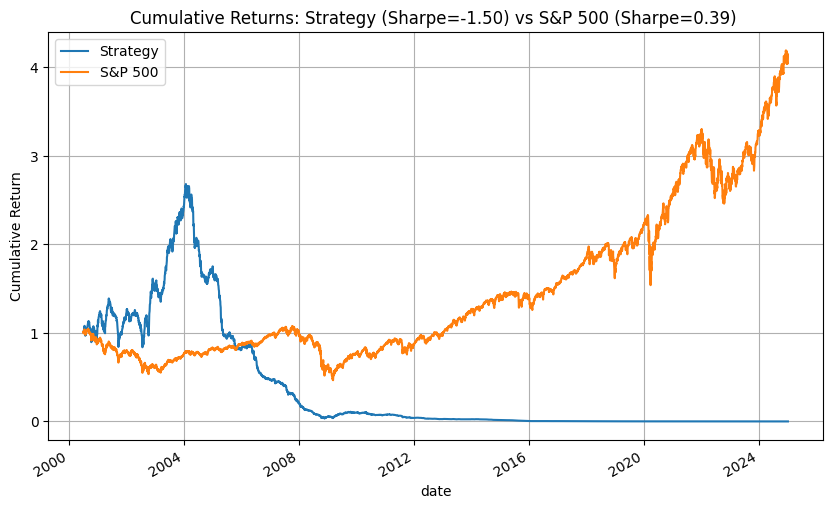

In [6]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[6].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = utils.compute_sharpe(combined_returns)
sp_sharpe = utils.compute_sharpe(sp_ret)

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe:.2f}) vs S&P 500 (Sharpe={sp_sharpe:.2f}) ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------------------------------------

# Let's run from 2020-04 to 2024-12 using linear rank loss without firm characteristics

In [3]:
daily = utils.read_daily_returns(path, skiprows=range(1, 44000000), header=0, low_quantile=0.005, up_quantile=0.995)
daily

Number of daily return outliers: 26,885


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2023-11-15,37493,20703,6726,525990,-0.001460,0.001597,0.000000
1,2023-11-15,37493,21220,6726,525990,-0.003876,0.001597,0.000000
2,2023-11-15,37493,21406,6726,525990,0.009259,0.001597,0.000000
3,2023-11-15,37493,21407,6726,525990,-0.003561,0.001597,0.000000
4,2023-11-15,37493,21656,6726,525990,-0.001888,0.001597,0.000000
...,...,...,...,...,...,...,...,...
2688523,2024-12-31,60118,26023,9999,0,-0.000393,-0.004285,-0.010702
2688524,2024-12-31,60120,26027,9999,523910,-0.133368,-0.004285,-0.010702
2688525,2024-12-31,60121,26034,9999,0,0.108590,-0.004285,-0.010702
2688526,2024-12-31,60122,26035,9999,551112,-0.034979,-0.004285,-0.010702


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
cutoff = unique_months.iloc[6]
cutoff

Period('2024-05', 'M')

In [5]:
daily = daily[daily['year_month'] >= cutoff]
daily.reset_index(drop=True, inplace=True)
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1,year_month
0,2024-05-01,5,15580,6320,524113,-0.040867,-0.003435,-0.015731,2024-05
1,2024-05-01,7,14593,3571,334220,-0.006047,-0.003435,-0.015731,2024-05
2,2024-05-01,33,59248,2082,312120,-0.003144,-0.003435,-0.015731,2024-05
3,2024-05-01,33,90562,2082,312120,0.028959,-0.003435,-0.015731,2024-05
4,2024-05-01,59,61487,5172,424720,-0.016949,-0.003435,-0.015731,2024-05
...,...,...,...,...,...,...,...,...,...
1616686,2024-12-31,60118,26023,9999,0,-0.000393,-0.004285,-0.010702,2024-12
1616687,2024-12-31,60120,26027,9999,523910,-0.133368,-0.004285,-0.010702,2024-12
1616688,2024-12-31,60121,26034,9999,0,0.108590,-0.004285,-0.010702,2024-12
1616689,2024-12-31,60122,26035,9999,551112,-0.034979,-0.004285,-0.010702,2024-12


In [6]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616691 entries, 0 to 1616690
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   date         1616691 non-null  datetime64[ns]
 1   PERMCO       1616691 non-null  int64         
 2   PERMNO       1616691 non-null  int64         
 3   SICCD        1616691 non-null  int64         
 4   NAICS        1616691 non-null  int64         
 5   DlyRet       1616691 non-null  float64       
 6   sprtrn       1616691 non-null  float64       
 7   sprtrn_lag1  1616691 non-null  float64       
 8   year_month   1616691 non-null  period[M]     
dtypes: datetime64[ns](1), float64(3), int64(4), period[M](1)
memory usage: 111.0 MB


In [6]:
def run(data, unique_months, start_index=0, TC_RATES=[0.001, 0.002, 0.003]):
    # Initialize a dictionary to store DataFrames for each rate
    all_strategy_returns = {f'return_{rate}': [] for rate in TC_RATES}
    
    for i in range(start_index, len(unique_months) - 6):

        # Train on 6 months of data and test on 1 month
        train_start = unique_months.iloc[i]
        train_end = unique_months.iloc[i+5]
        test_month = unique_months.iloc[i+6]

        print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
        # Filter data
        train_mask = (data['year_month'] >= train_start) & (data['year_month'] <= train_end)
        test_mask = data['year_month'] == test_month

        tr_df = data[train_mask].copy()
        te_df = data[test_mask].copy()

        # Prepare the data: construct lagged returns, rolling window averages
        train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
        epochs = 6 # Optimal trade-off for this strategy
        train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, loss_function = 'lin_rank')
        
        test_df['weight'] = weights.values
        test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    
        # Deduct transaction costs 
        alpha = 100 # Best for scale of weights

        # Track return for each level of transaction costs
        for rate in TC_RATES:
            key = f'return_{rate}'
                 
            test_df[f'tc_cost_{rate}'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=rate, alpha=alpha))
            test_df[f'strategy_return_{rate}'] = test_df['weight'] * test_df['DlyRet'] - test_df[f'tc_cost_{rate}']
            mean_daily_returns = test_df.groupby('date')[f'strategy_return_{rate}'].sum()
            
            # Convert to DataFrame and store
            returns_df = mean_daily_returns.to_frame(name='returns')
            returns_df['rate'] = rate
            all_strategy_returns[key].append(returns_df) 
            
        gc.collect() # Memory clean-up

    combined_returns = {}
    for key in all_strategy_returns:
        if all_strategy_returns[key]:  # check if list is not empty
            combined_returns[key] = pd.concat(all_strategy_returns[key])

    # Combine into single data frame
    final_combined = pd.concat(combined_returns.values(), keys=combined_returns.keys())
    final_combined = final_combined.drop(columns=['rate'])
    return final_combined
    

In [7]:
combined_returns = run(daily, unique_months, start_index=6)

Training from 2024-05 to 2024-10. Testing on 2024-11.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 596 train batches, 48 test batches


Training:  17%|█████▊                             | 1/6 [00:38<03:10, 38.18s/it]

Epoch 1/6, Loss: -0.0115, Train fit: 0.0058, Test fit: 0.0273, Avg Weight: 0.0002, Max Weight: 0.0219


Training:  50%|█████████████████▌                 | 3/6 [01:58<01:59, 39.75s/it]

Epoch 3/6, Loss: -0.0092, Train fit: 0.0050, Test fit: 0.0023, Avg Weight: 0.0002, Max Weight: 0.0219


Training:  83%|█████████████████████████████▏     | 5/6 [03:18<00:39, 39.64s/it]

Epoch 5/6, Loss: -0.0155, Train fit: 0.0102, Test fit: 0.0115, Avg Weight: 0.0002, Max Weight: 0.0219


Training: 100%|███████████████████████████████████| 6/6 [03:51<00:00, 38.62s/it]

Epoch 6/6, Loss: -0.0187, Train fit: 0.0116, Test fit: 0.0205, Avg Weight: 0.0002, Max Weight: 0.0219
Training completed! Best test Sharpe ratio: 0.0273


Training from 2024-06 to 2024-11. Testing on 2024-12.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 589 train batches, 50 test batches


Training:  17%|█████▊                             | 1/6 [00:36<03:01, 36.26s/it]

Epoch 1/6, Loss: -0.0075, Train fit: 0.0086, Test fit: -0.0225, Avg Weight: 0.0002, Max Weight: 0.0059


Training:  50%|█████████████████▌                 | 3/6 [01:49<01:49, 36.43s/it]

Epoch 3/6, Loss: -0.0139, Train fit: 0.0092, Test fit: -0.0022, Avg Weight: 0.0002, Max Weight: 1.0000


Training:  83%|█████████████████████████████▏     | 5/6 [02:58<00:35, 35.25s/it]

Epoch 5/6, Loss: -0.0145, Train fit: 0.0087, Test fit: -0.0202, Avg Weight: 0.0002, Max Weight: 1.0000


Training: 100%|███████████████████████████████████| 6/6 [03:32<00:00, 35.44s/it]

Epoch 6/6, Loss: -0.0157, Train fit: 0.0082, Test fit: -0.0196, Avg Weight: 0.0002, Max Weight: 1.0000
Training completed! Best test Sharpe ratio: -0.0022


In [8]:
def plot_cumulative_returns(combined_returns, unique_months, start_index=0):
    # Unstack the returns to get one column per strategy
    returns_df = combined_returns['returns'].unstack(level=0)
    
    # Compute cumulative returns
    cumulative_returns = (1 + returns_df).cumprod()
    
    # Process benchmark S&P 500
    sp_ret = daily.groupby('date')['sprtrn'].mean()
    strat_start = unique_months.iloc[start_index].to_timestamp()
    sp_ret = sp_ret.loc[strat_start:]
    cumulative_returns['S&P 500'] = (1 + sp_ret).cumprod()
    
    # Compute Sharpe ratios
    sharpe_ratios = {
        **{col: utils.compute_sharpe(returns_df[col]) for col in returns_df.columns},
        'S&P 500': utils.compute_sharpe(sp_ret)
    }
    
    # Plot
    plt.figure(figsize=(12, 6))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[col], label=f"{col} (Sharpe={sharpe_ratios[col]:.2f})")
    
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns with Sharpe Ratios')
    plt.legend(title="Strategy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

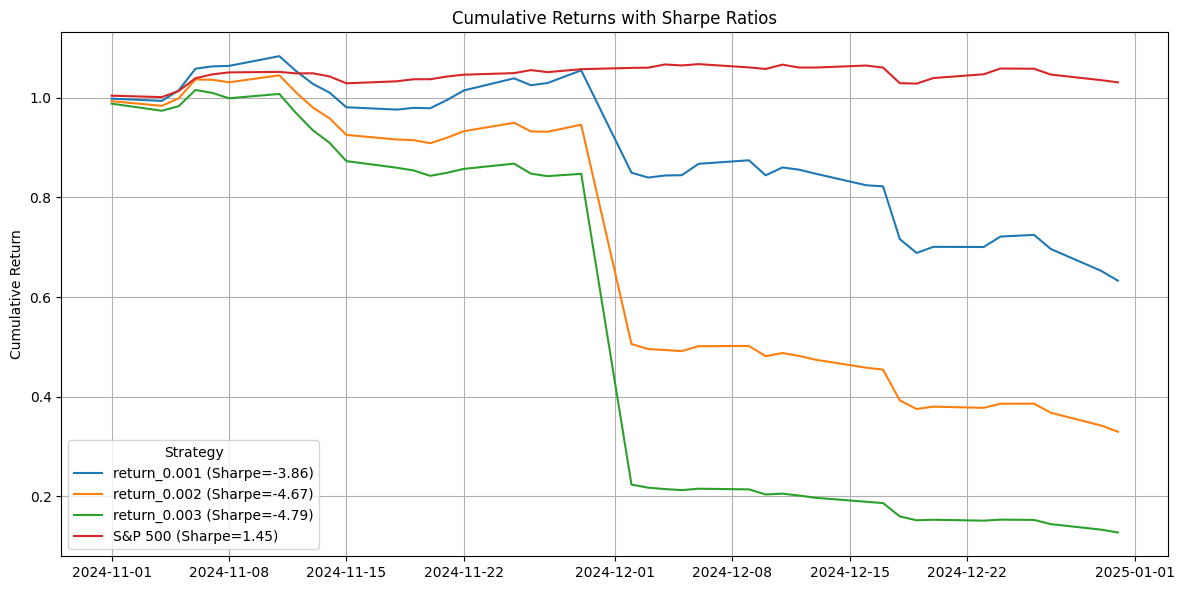

In [9]:
plot_cumulative_returns(combined_returns, unique_months, start_index=12)

# Let's add firm characteristics

In [10]:
gc.collect()
index = pd.read_csv('Predictors/FirmCharacIndex.csv')
index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517984 entries, 0 to 517983
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  517984 non-null  int64  
 1   date        517984 non-null  object 
 2   PERMNO      517984 non-null  int64  
 3   gvkey       517984 non-null  int64  
 4   pls_index   517984 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 19.8+ MB


In [11]:
merged_data = utils.memory_efficient_merge(index, daily)
merged_data = merged_data.drop(columns=['PERMNO_y'])
merged_data = merged_data.rename(columns={'PERMNO_x': 'PERMNO'})
merged_data

Processing PERMNOs: 100%|████████████████| 14453/14453 [00:21<00:00, 675.54it/s]


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1,year_month,pls_index
0,2024-05-01,7992,10044,2060,445292,-0.005587,-0.003435,-0.015731,2024-05,-3.216788
1,2024-05-02,7992,10044,2060,445292,0.011236,0.009128,-0.003435,2024-05,-3.216788
2,2024-05-03,7992,10044,2060,445292,-0.005556,0.012557,0.009128,2024-05,-3.216788
3,2024-05-06,7992,10044,2060,445292,-0.005587,0.010326,0.012557,2024-05,-3.216788
4,2024-05-07,7992,10044,2060,445292,-0.005618,0.001343,0.010326,2024-05,-3.216788
...,...,...,...,...,...,...,...,...,...,...
759392,2024-12-24,60095,25916,7371,541511,0.161620,0.011043,0.007287,2024-12,1.842029
759393,2024-12-26,60095,25916,7371,541511,0.096065,-0.000406,0.011043,2024-12,1.842029
759394,2024-12-27,60095,25916,7371,541511,-0.133368,-0.011056,-0.000406,2024-12,1.842029
759395,2024-12-30,60095,25916,7371,541511,-0.054425,-0.010702,-0.011056,2024-12,1.842029


In [12]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759397 entries, 0 to 759396
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         759397 non-null  datetime64[ns]
 1   PERMCO       759397 non-null  int64         
 2   PERMNO       759397 non-null  int32         
 3   SICCD        759397 non-null  int64         
 4   NAICS        759397 non-null  int64         
 5   DlyRet       759397 non-null  float64       
 6   sprtrn       759397 non-null  float64       
 7   sprtrn_lag1  759397 non-null  float64       
 8   year_month   759397 non-null  period[M]     
 9   pls_index    759397 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(3), period[M](1)
memory usage: 55.0 MB


In [13]:
combined_returns = run(merged_data, unique_months, start_index=6)

Training from 2024-05 to 2024-10. Testing on 2024-11.
['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 292 train batches, 20 test batches


Training:  17%|█████▊                             | 1/6 [00:19<01:35, 19.12s/it]

Epoch 1/6, Loss: -0.0135, Train fit: 0.0143, Test fit: 0.0387, Avg Weight: 0.0003, Max Weight: 0.0099


Training:  50%|█████████████████▌                 | 3/6 [00:53<00:52, 17.55s/it]

Epoch 3/6, Loss: -0.0141, Train fit: 0.0166, Test fit: 0.0378, Avg Weight: 0.0003, Max Weight: 0.0099


Training:  83%|█████████████████████████████▏     | 5/6 [01:28<00:17, 17.51s/it]

Epoch 5/6, Loss: -0.0120, Train fit: 0.0139, Test fit: 0.0376, Avg Weight: 0.0003, Max Weight: 0.0099


Training: 100%|███████████████████████████████████| 6/6 [01:46<00:00, 17.81s/it]

Epoch 6/6, Loss: -0.0159, Train fit: 0.0178, Test fit: 0.0433, Avg Weight: 0.0003, Max Weight: 0.0099
Training completed! Best test Sharpe ratio: 0.0433
Training from 2024-06 to 2024-11. Testing on 2024-12.


['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 280 train batches, 20 test batches


Training:  17%|█████▊                             | 1/6 [00:16<01:20, 16.06s/it]

Epoch 1/6, Loss: -0.0113, Train fit: 0.0167, Test fit: -0.0377, Avg Weight: 0.0002, Max Weight: 0.0052


Training:  50%|█████████████████▌                 | 3/6 [00:49<00:49, 16.60s/it]

Epoch 3/6, Loss: -0.0142, Train fit: 0.0186, Test fit: -0.0377, Avg Weight: 0.0002, Max Weight: 0.0052


Training:  83%|█████████████████████████████▏     | 5/6 [01:25<00:17, 17.40s/it]

Epoch 5/6, Loss: -0.0175, Train fit: 0.0188, Test fit: -0.0479, Avg Weight: 0.0002, Max Weight: 0.0052


Training: 100%|███████████████████████████████████| 6/6 [01:41<00:00, 16.86s/it]

Epoch 6/6, Loss: -0.0173, Train fit: 0.0189, Test fit: -0.0445, Avg Weight: 0.0002, Max Weight: 0.0052
Training completed! Best test Sharpe ratio: -0.0369


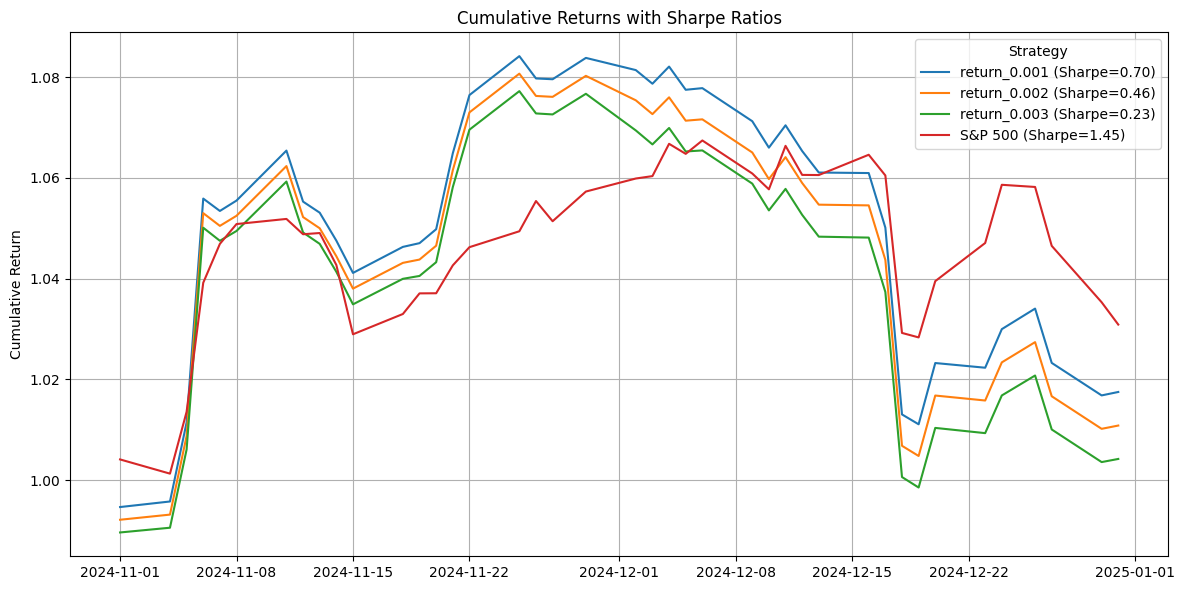

In [14]:
plot_cumulative_returns(combined_returns, unique_months, start_index=12)